Summary:
Total number of pieces: 254
Total area needed: 440.15 sqm
Estimated sheets needed (3300 x 2438): 55
Estimated wastage: 0.53%


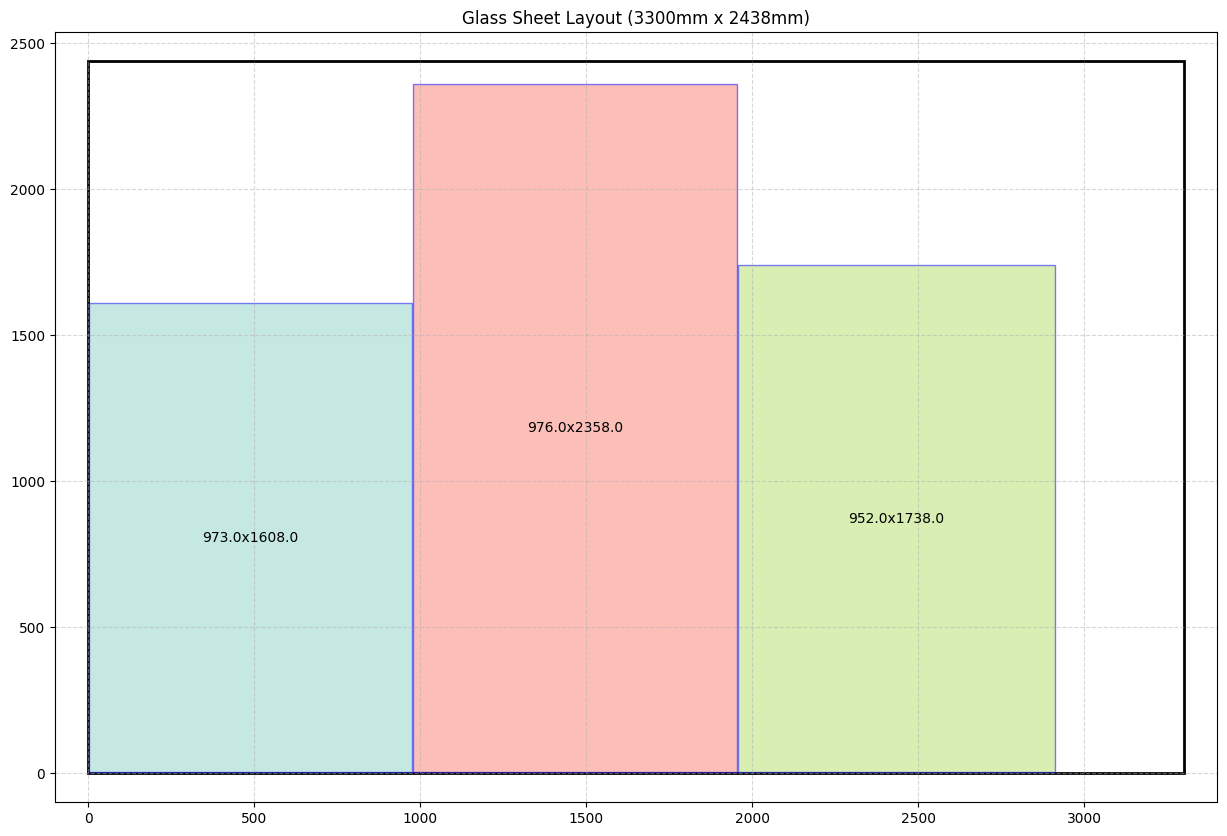

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Clean and prepare the data
glass_df = pd.read_csv('data/glass_data.csv')
glass_df = glass_df.iloc[1:] # Skip the header row
glass_df.columns = ['location', 'glass_length', 'glass_height', 'glass_qty', 'area_sqm']
glass_df = glass_df.astype({'glass_length': float, 'glass_height': float, 'glass_qty': int, 'area_sqm': float})

# Calculate total area needed and sheets required for each size
sheet_sizes = [(3300, 2438), (3300, 2100), (2438, 2100)]
total_pieces = glass_df['glass_qty'].sum()
total_area_needed = glass_df['area_sqm'].sum()

# Calculate sheets needed for each size (using the largest sheet size as default)
max_sheet_area = (3300 * 2438) / 1000000  # Convert to sqm
sheets_needed = np.ceil(total_area_needed / max_sheet_area)

# Calculate wastage
total_sheet_area = sheets_needed * max_sheet_area
wastage_percentage = ((total_sheet_area - total_area_needed) / total_sheet_area) * 100

print("Summary:")
print(f"Total number of pieces: {total_pieces}")
print(f"Total area needed: {total_area_needed:.2f} sqm")
print(f"Estimated sheets needed (3300 x 2438): {int(sheets_needed)}")
print(f"Estimated wastage: {wastage_percentage:.2f}%")

# Visualization of one sheet with pieces (example for first sheet)
def plot_sheet_layout(sheet_size, pieces):
    fig, ax = plt.subplots(figsize=(15, 10))
    sheet_width, sheet_height = sheet_size
    
    # Draw sheet
    rect = patches.Rectangle((0, 0), sheet_width, sheet_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
    # Plot some example pieces with 3mm spacing
    current_x = 3
    current_y = 3
    colors = plt.cm.Set3(np.linspace(0, 1, len(pieces)))
    
    for i, (length, height, qty) in enumerate(pieces):
        if current_x + length + 3 <= sheet_width and current_y + height + 3 <= sheet_height:
            rect = patches.Rectangle((current_x, current_y), length, height, 
                                  linewidth=1, edgecolor='blue', facecolor=colors[i], alpha=0.5)
            ax.add_patch(rect)
            plt.text(current_x + length/2, current_y + height/2, f'{length}x{height}', 
                    ha='center', va='center')
            current_x += length + 3
        
    ax.set_xlim(-100, sheet_width + 100)
    ax.set_ylim(-100, sheet_height + 100)
    ax.set_title(f'Glass Sheet Layout ({sheet_width}mm x {sheet_height}mm)')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example layout for first sheet
example_pieces = glass_df[['glass_length', 'glass_height', 'glass_qty']].values[:5]
plot_sheet_layout((3300, 2438), example_pieces)

In [2]:
# Simple cutting stock optimization
import pandas as pd
import numpy as np

def calculate_sheets_needed(piece_length, piece_width, piece_qty, stock_length, stock_width):
    # Calculate how many pieces fit in one sheet
    pieces_per_length = int(stock_length / piece_length)
    pieces_per_width = int(stock_width / piece_width)
    
    pieces_per_sheet = pieces_per_length * pieces_per_width
    if pieces_per_sheet == 0:
        # Try rotating the piece
        pieces_per_length = int(stock_length / piece_width)
        pieces_per_width = int(stock_width / piece_length)
        pieces_per_sheet = pieces_per_length * pieces_per_width
    
    if pieces_per_sheet == 0:
        return float('inf')
    
    return np.ceil(piece_qty / pieces_per_sheet)

glass_data = pd.read_csv('data/glass_data.csv')
stock_sizes = pd.read_csv('data/glass_sheet_size.csv')

# Calculate sheets needed for each stock size
results = []
for _, stock in stock_sizes.iterrows():
    total_sheets = 0
    for _, glass in glass_data.iterrows():
        sheets = calculate_sheets_needed(
            glass['glass_length'], 
            glass['glass_height'],
            glass['glass_qty'],
            stock['length'],
            stock['width']
        )
        total_sheets += sheets
    
    results.append({
        'stock_size': f"{stock['length']}x{stock['width']}",
        'sheets_needed': total_sheets
    })

results_df = pd.DataFrame(results)
print("Recommended sheets needed for each stock size:")
display(results_df)

Recommended sheets needed for each stock size:


,stock_size,sheets_needed
0,2100x2438,134.0
1,2438x2100,134.0
2,3300x2100,99.0
3,2100x3300,98.0
4,3300x2438,90.0
5,2438x3300,98.0


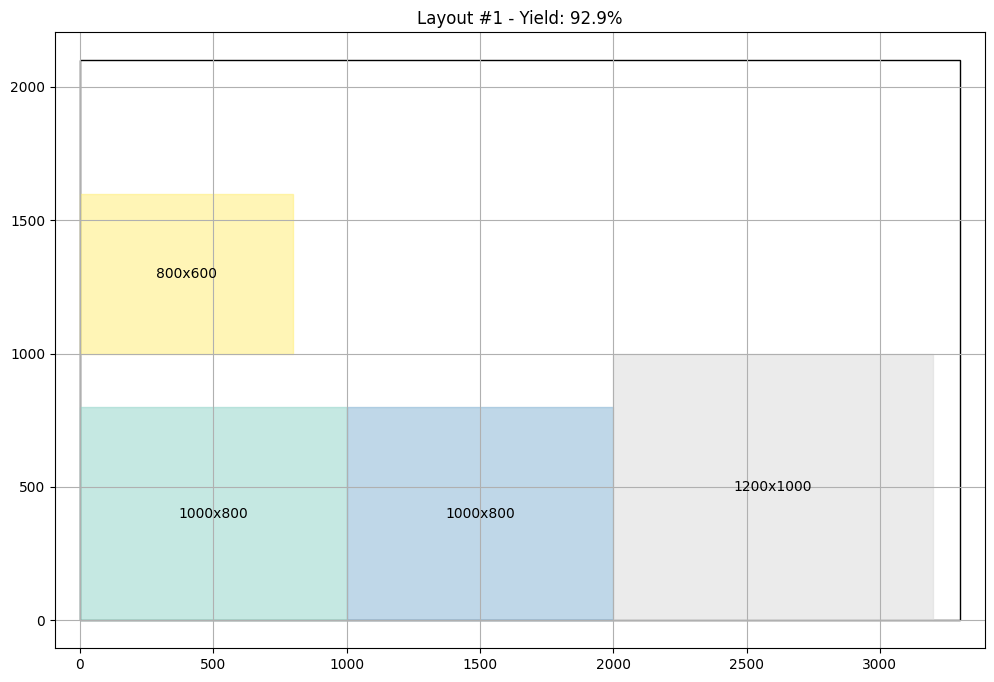

This is an example layout. Would you like to:
1. Generate all layouts
2. Optimize for specific glass dimensions
3. Calculate material costs
4. Something else?


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a function to visualize the cutting pattern
def visualize_cutting_pattern(stock_width, stock_length, pieces, layout_num, yield_pct):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw stock sheet
    rect = plt.Rectangle((0, 0), stock_width, stock_length, fill=False, color='black')
    ax.add_patch(rect)
    
    # Place pieces
    colors = plt.cm.Set3(np.linspace(0, 1, len(pieces)))
    current_x = 0
    current_y = 0
    max_height = 0
    
    for i, (width, length) in enumerate(pieces):
        if current_x + width > stock_width:
            current_x = 0
            current_y += max_height
            max_height = 0
            
        if current_y + length <= stock_length:
            rect = plt.Rectangle((current_x, current_y), width, length, 
                               fill=True, color=colors[i], alpha=0.5)
            ax.add_patch(rect)
            # Add text in the middle of each piece
            plt.text(current_x + width/2, current_y + length/2, 
                    f'{width}x{length}', ha='center', va='center')
            
            current_x += width
            max_height = max(max_height, length)
    
    plt.title(f'Layout #{layout_num} - Yield: {yield_pct}%')
    ax.set_xlim(-50, stock_width + 50)
    ax.set_ylim(-50, stock_length + 50)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Example for Layout #1 (92.9% yield)
stock_width = 3300
stock_length = 2100
pieces = [
    (1000, 800),
    (1000, 800),
    (1200, 1000),
    (800, 600)
]

visualize_cutting_pattern(stock_width, stock_length, pieces, 1, 92.9)

print("This is an example layout. Would you like to:")
print("1. Generate all layouts")
print("2. Optimize for specific glass dimensions")
print("3. Calculate material costs")
print("4. Something else?")

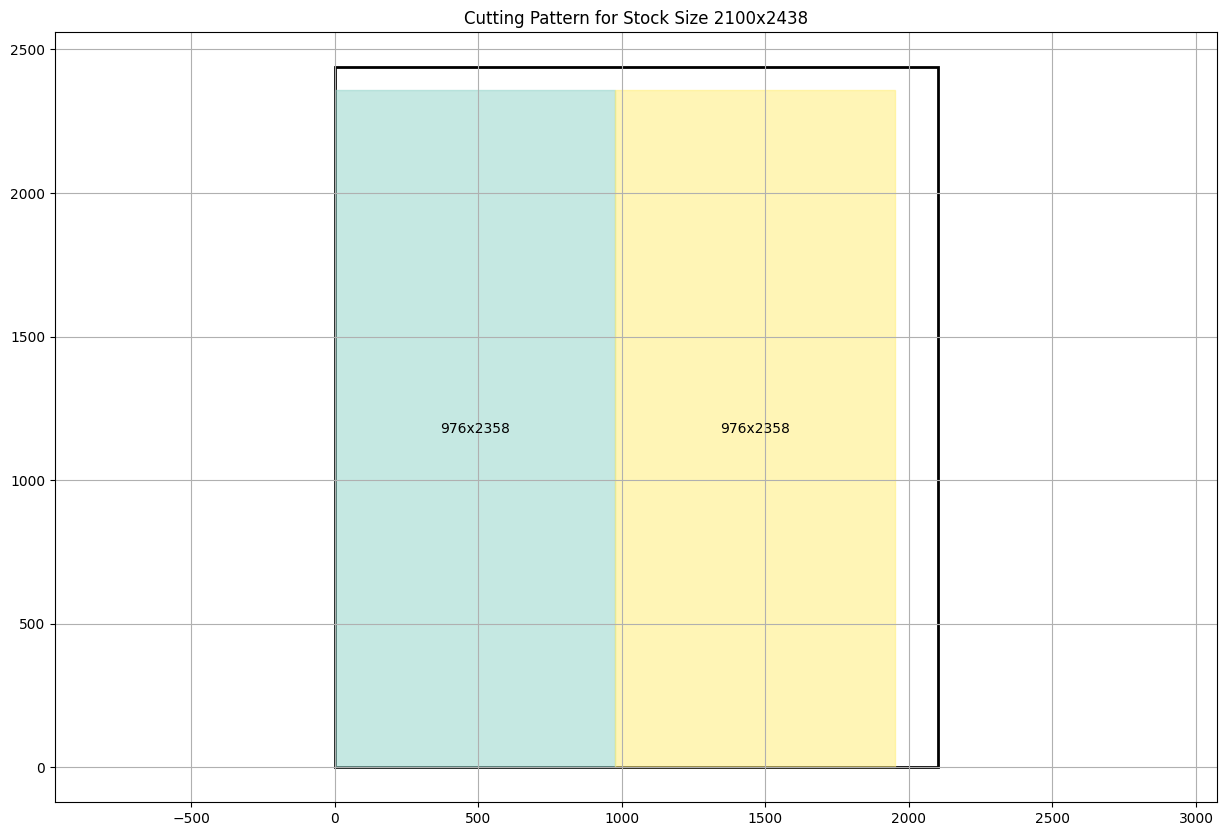

Yield: 89.9%
Number of pieces placed: 2


In [4]:
# Create dataframes for glass pieces and stock sizes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

glass_data = pd.read_csv('data/glass_data.csv')
stock_sizes = pd.read_csv('data/glass_sheet_size.csv')

def optimize_cutting_pattern(stock_size, pieces):
    def can_fit(piece, space, rotated=False):
        piece_w, piece_h = (piece[1], piece[0]) if rotated else (piece[0], piece[1])
        return piece_w <= space[0] and piece_h <= space[1]
    
    def find_best_fit(space, remaining_pieces):
        best_waste = float('inf')
        best_piece = None
        best_rotated = False
        best_idx = -1
        
        for idx, piece in enumerate(remaining_pieces):
            # Try normal orientation
            if can_fit(piece, space):
                waste = (space[0] * space[1]) - (piece[0] * piece[1])
                if waste < best_waste:
                    best_waste = waste
                    best_piece = piece
                    best_rotated = False
                    best_idx = idx
            
            # Try rotated
            if can_fit(piece, space, True):
                waste = (space[0] * space[1]) - (piece[0] * piece[1])
                if waste < best_waste:
                    best_waste = waste
                    best_piece = piece
                    best_rotated = True
                    best_idx = idx
                    
        return best_piece, best_rotated, best_idx

    placements = []
    stock_w, stock_h = stock_size
    
    # Convert pieces to list of tuples (length, height, qty)
    pieces_list = [(row['glass_length'], row['glass_height'], row['glass_qty']) 
                   for _, row in pieces.iterrows()]
    
    remaining_space = [(0, 0, stock_w, stock_h)]
    
    while remaining_space and pieces_list:
        x, y, width, height = remaining_space.pop(0)
        piece, rotated, idx = find_best_fit((width, height), 
                                          [(l, h) for l, h, _ in pieces_list])
        
        if piece is None:
            continue
            
        piece_w, piece_h = (piece[1], piece[0]) if rotated else (piece[0], piece[1])
        placements.append((x, y, piece_w, piece_h))
        
        # Update remaining pieces
        pieces_list[idx] = (pieces_list[idx][0], pieces_list[idx][1], 
                           pieces_list[idx][2] - 1)
        if pieces_list[idx][2] == 0:
            pieces_list.pop(idx)
            
        # Calculate new remaining spaces
        if y + piece_h < stock_h:
            remaining_space.append((x, y + piece_h, width, stock_h - (y + piece_h)))
        if x + piece_w < stock_w:
            remaining_space.append((x + piece_w, y, stock_w - (x + piece_w), piece_h))
            
    return placements

# Test optimization for first stock size
stock_size = (stock_sizes.iloc[0]['length'], stock_sizes.iloc[0]['width'])
placements = optimize_cutting_pattern(stock_size, glass_data)

# Visualize the result
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Draw stock sheet
rect = plt.Rectangle((0, 0), stock_size[0], stock_size[1], 
                    fill=False, color='black', linewidth=2)
ax.add_patch(rect)

# Draw placed pieces
colors = plt.cm.Set3(np.linspace(0, 1, len(placements)))
for (x, y, w, h), color in zip(placements, colors):
    rect = plt.Rectangle((x, y), w, h, fill=True, color=color, alpha=0.5)
    ax.add_patch(rect)
    plt.text(x + w/2, y + h/2, f'{w}x{h}', ha='center', va='center')

plt.title(f'Cutting Pattern for Stock Size {stock_size[0]}x{stock_size[1]}')
ax.set_xlim(-100, stock_size[0] + 100)
ax.set_ylim(-100, stock_size[1] + 100)
plt.axis('equal')
plt.grid(True)
plt.show()

# Calculate yield
total_piece_area = sum(w * h for _, _, w, h in placements)
stock_area = stock_size[0] * stock_size[1]
yield_pct = (total_piece_area / stock_area) * 100

print(f"Yield: {yield_pct:.1f}%")
print(f"Number of pieces placed: {len(placements)}")

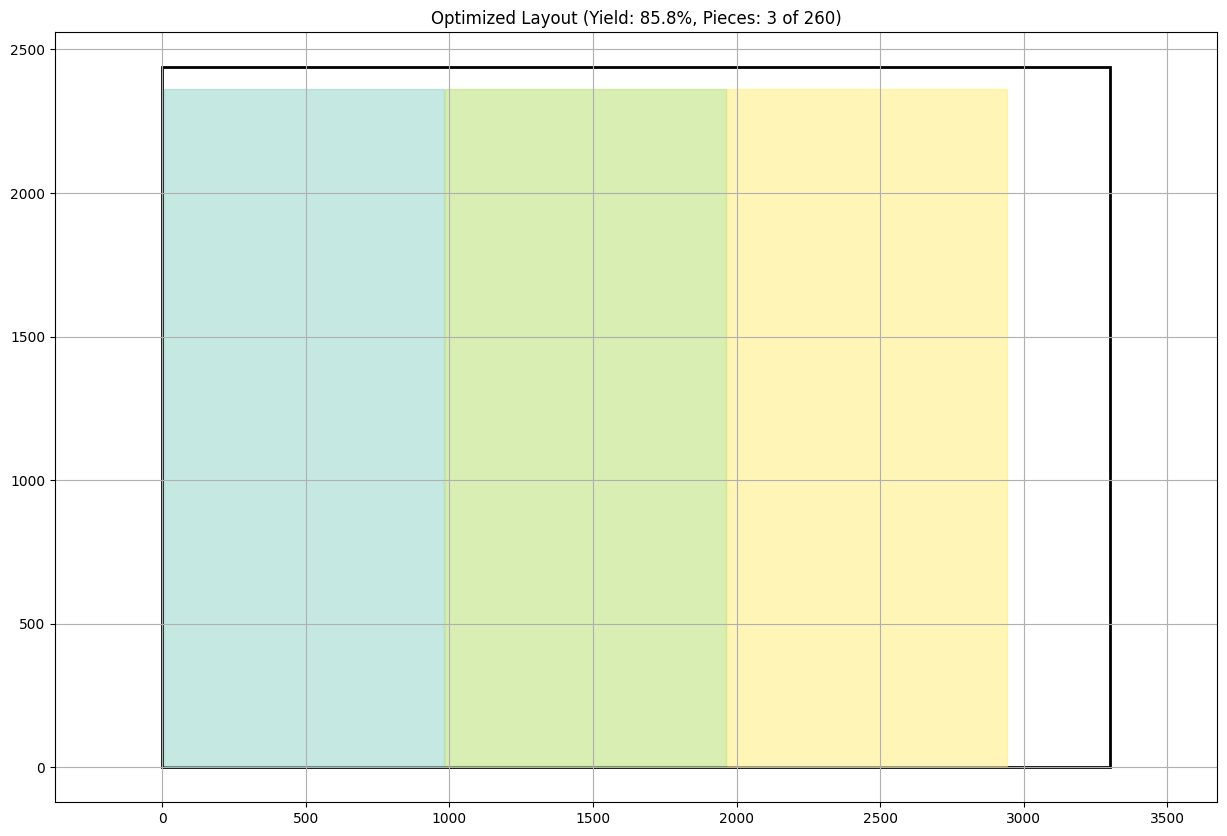

Total pieces: 260
Pieces placed: 3
Yield: 85.8%
Remaining pieces: 257


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Create expanded dataset with all pieces
# glass_data = pd.DataFrame({
#     'glass_length': [973, 973, 976, 952, 1010, 964, 964, 951, 951, 954, 954, 967],
#     'glass_height': [1883, 1608, 2358, 1738, 1594, 1603, 1902, 2263, 2218, 2268, 2218, 2328],
#     'glass_qty': [6, 12, 3, 45, 75, 56, 14, 7, 7, 7, 7, 21]
# })

glass_data = pd.read_csv('data/glass_data.csv')
stock_sizes = pd.read_csv('data/glass_sheet_size.csv')

# Expand the data to create individual rows for each piece
expanded_glass_data = pd.DataFrame([
    [length, height] for length, height, qty in 
    zip(glass_data['glass_length'], glass_data['glass_height'], glass_data['glass_qty'])
    for _ in range(qty)
], columns=['length', 'height'])

def optimize_sheet(stock_size: Tuple[int, int], pieces: List[Tuple[int, int]], spacing: int = 5):
    stock_width, stock_height = stock_size
    placements = []
    current_x = spacing
    current_y = spacing
    row_height = 0
    
    # Sort pieces by height descending
    pieces = sorted(pieces, key=lambda x: (x[1], x[0]), reverse=True)
    
    for piece in pieces:
        width, height = piece
        
        # Check if piece fits in current row with spacing
        if current_x + width + spacing > stock_width:
            # Move to next row
            current_x = spacing
            current_y += row_height + spacing
            row_height = 0
            
        # Check if piece fits in sheet height
        if current_y + height + spacing > stock_height:
            break
            
        # Place piece
        placements.append((current_x, current_y, width, height))
        current_x += width + spacing
        row_height = max(row_height, height)
    
    return placements

def visualize_layout(stock_size: Tuple[int, int], placements: List[Tuple[int, int, int, int]], title: str):
    plt.figure(figsize=(15, 10))
    ax = plt.gca()
    
    # Draw stock sheet
    rect = plt.Rectangle((0, 0), stock_size[0], stock_size[1], fill=False, color='black', linewidth=2)
    ax.add_patch(rect)
    
    # Draw pieces
    colors = plt.cm.Set3(np.linspace(0, 1, len(placements)))
    for (x, y, w, h), color in zip(placements, colors):
        rect = plt.Rectangle((x, y), w, h, fill=True, color=color, alpha=0.5)
        ax.add_patch(rect)
        
    plt.title(title)
    ax.set_xlim(-100, stock_size[0] + 100)
    ax.set_ylim(-100, stock_size[1] + 100)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Test with largest stock size
stock_size = (3300, 2438)
pieces = list(zip(expanded_glass_data['length'], expanded_glass_data['height']))
placements = optimize_sheet(stock_size, pieces)

# Calculate yield
total_piece_area = sum(w * h for _, _, w, h in placements)
stock_area = stock_size[0] * stock_size[1]
yield_pct = (total_piece_area / stock_area) * 100

visualize_layout(stock_size, placements, 
                f'Optimized Layout (Yield: {yield_pct:.1f}%, Pieces: {len(placements)} of {len(pieces)})')

print(f"Total pieces: {len(pieces)}")
print(f"Pieces placed: {len(placements)}")
print(f"Yield: {yield_pct:.1f}%")
print(f"Remaining pieces: {len(pieces) - len(placements)}")

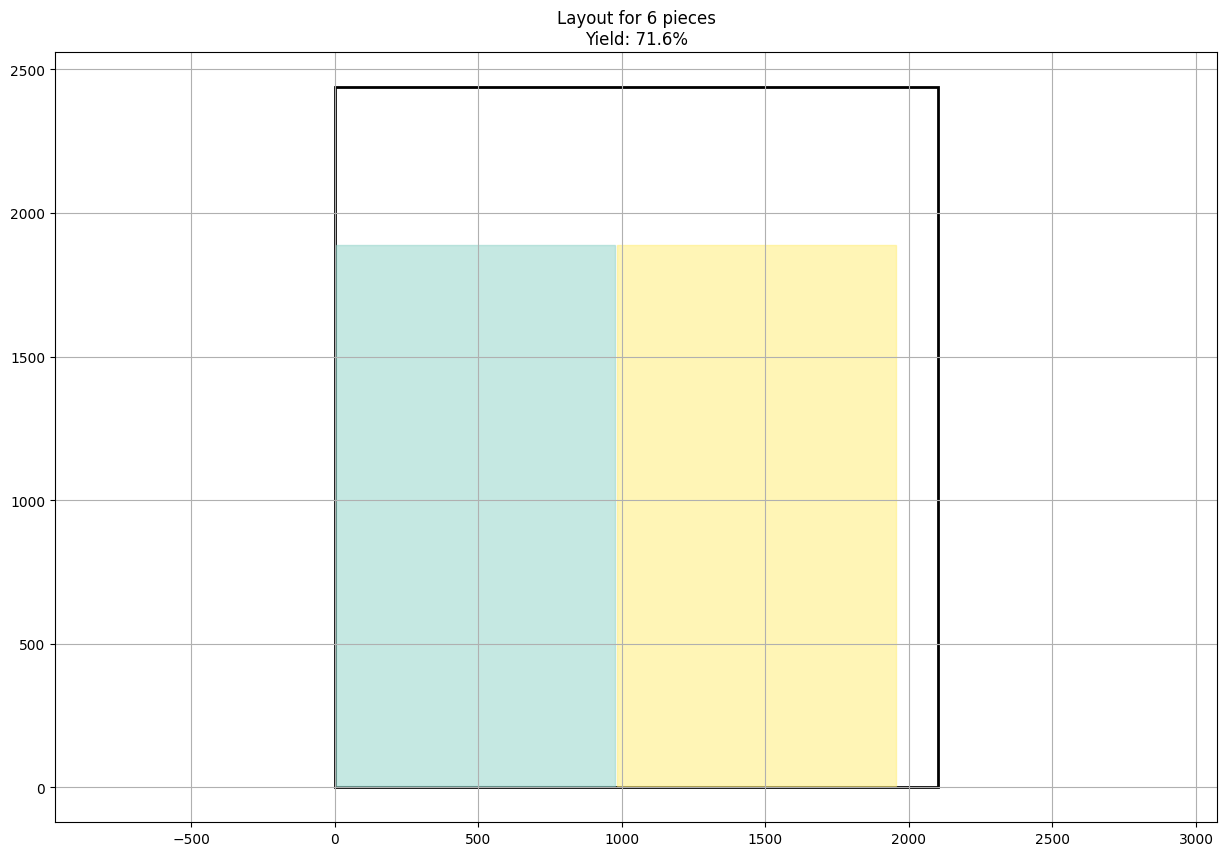

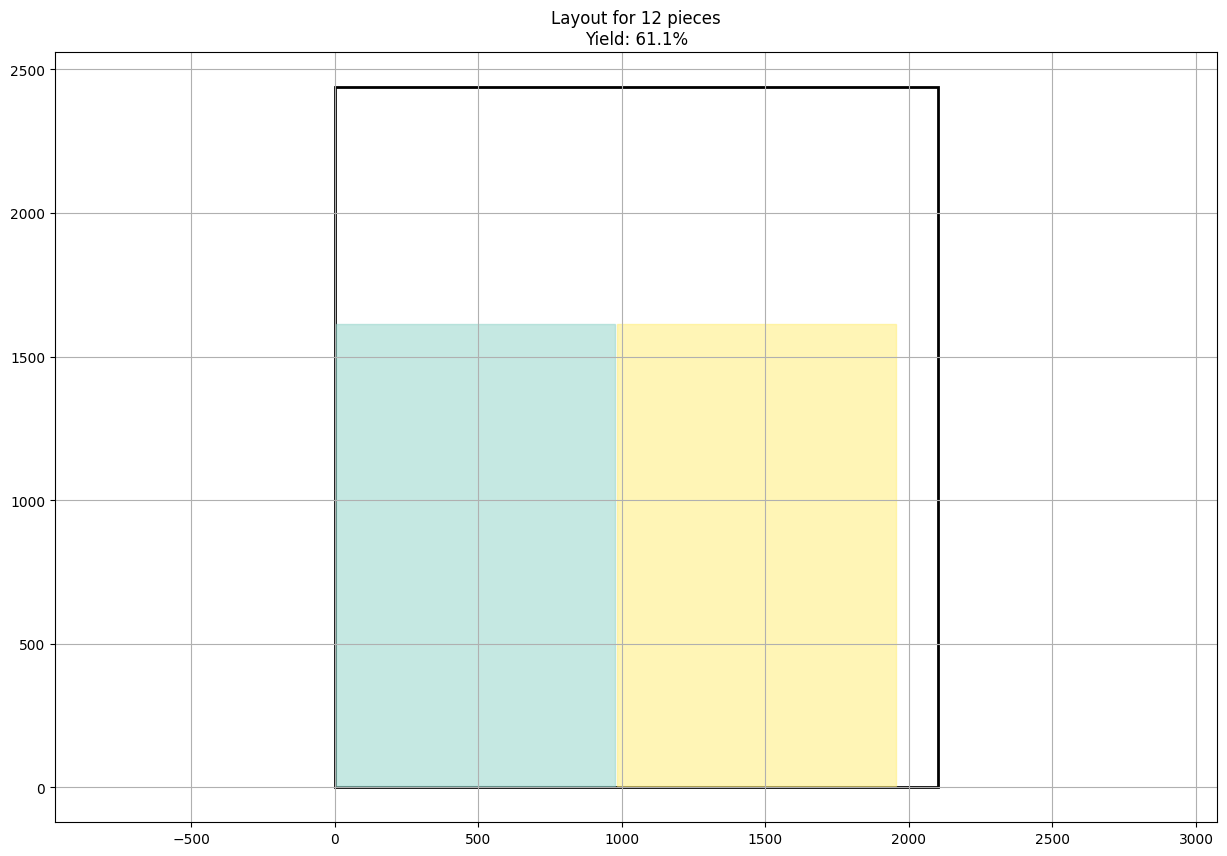

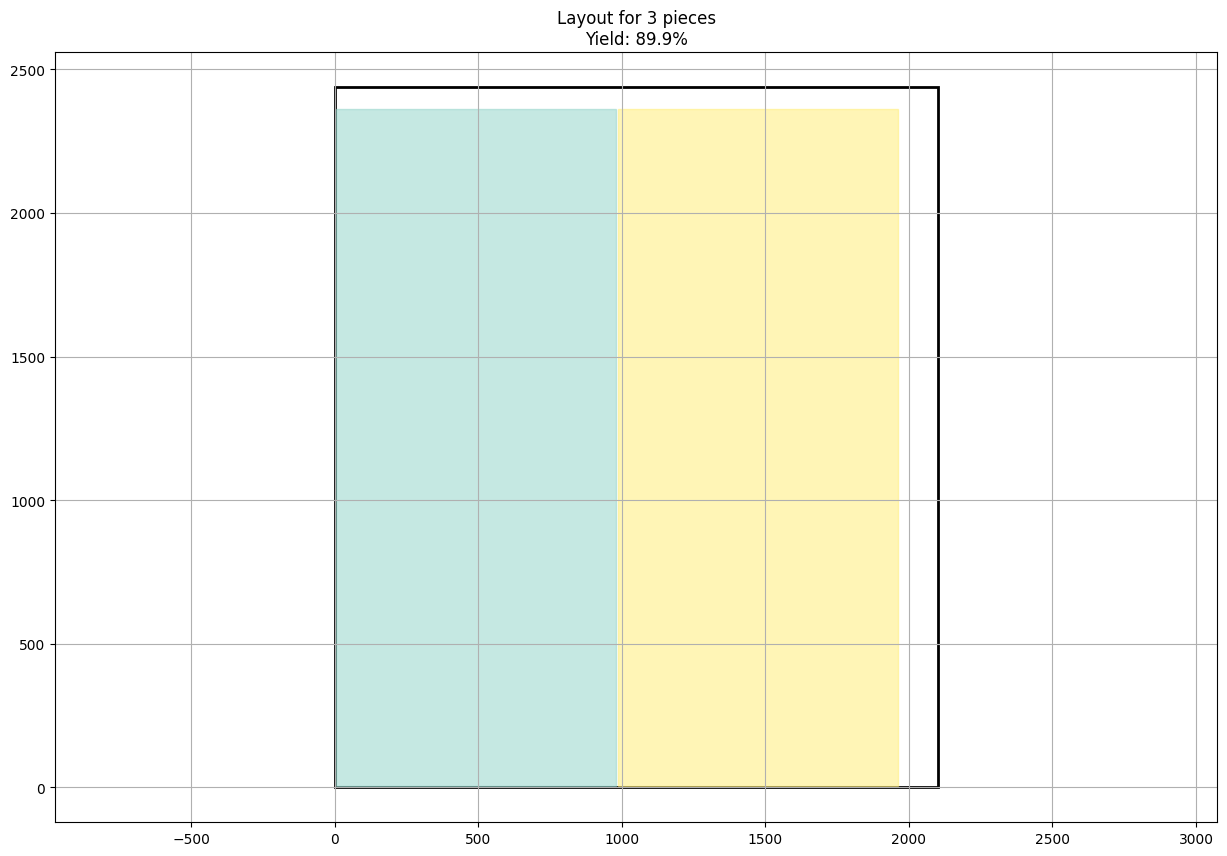

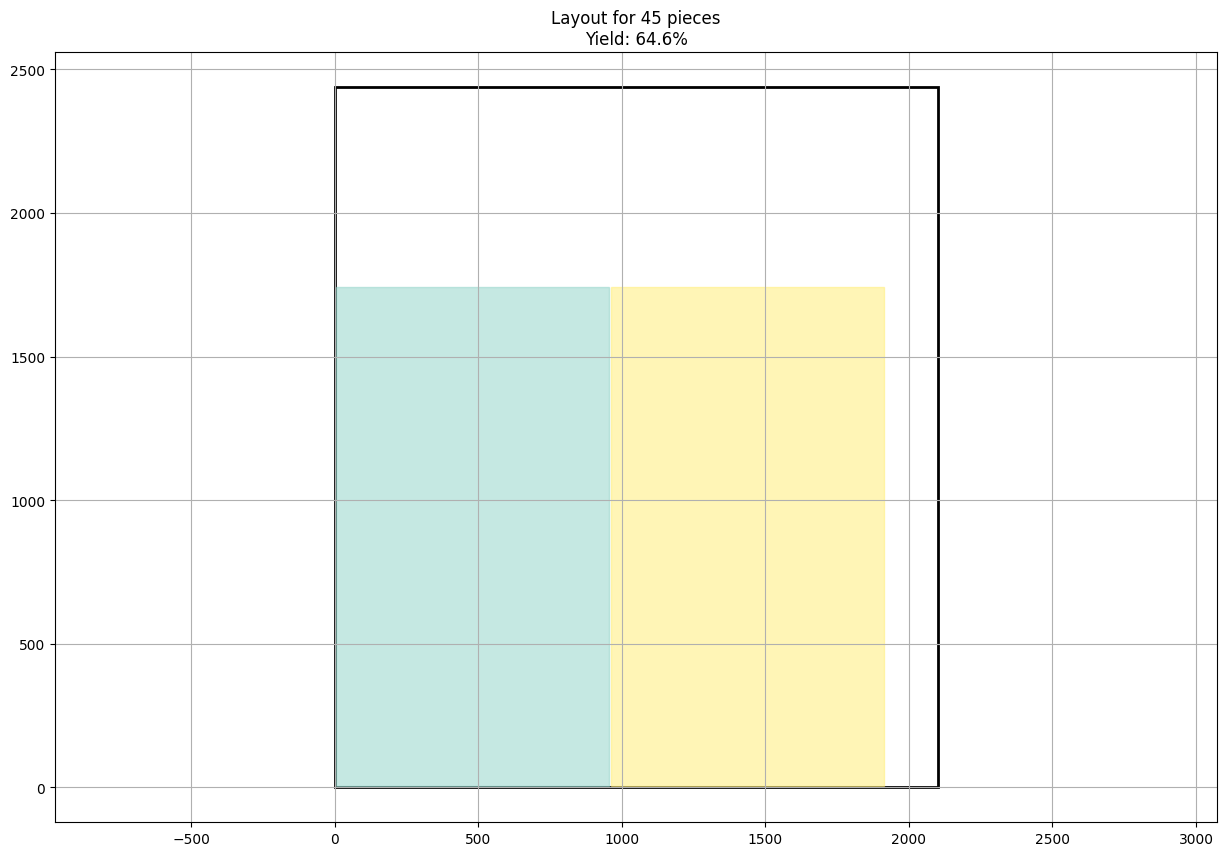

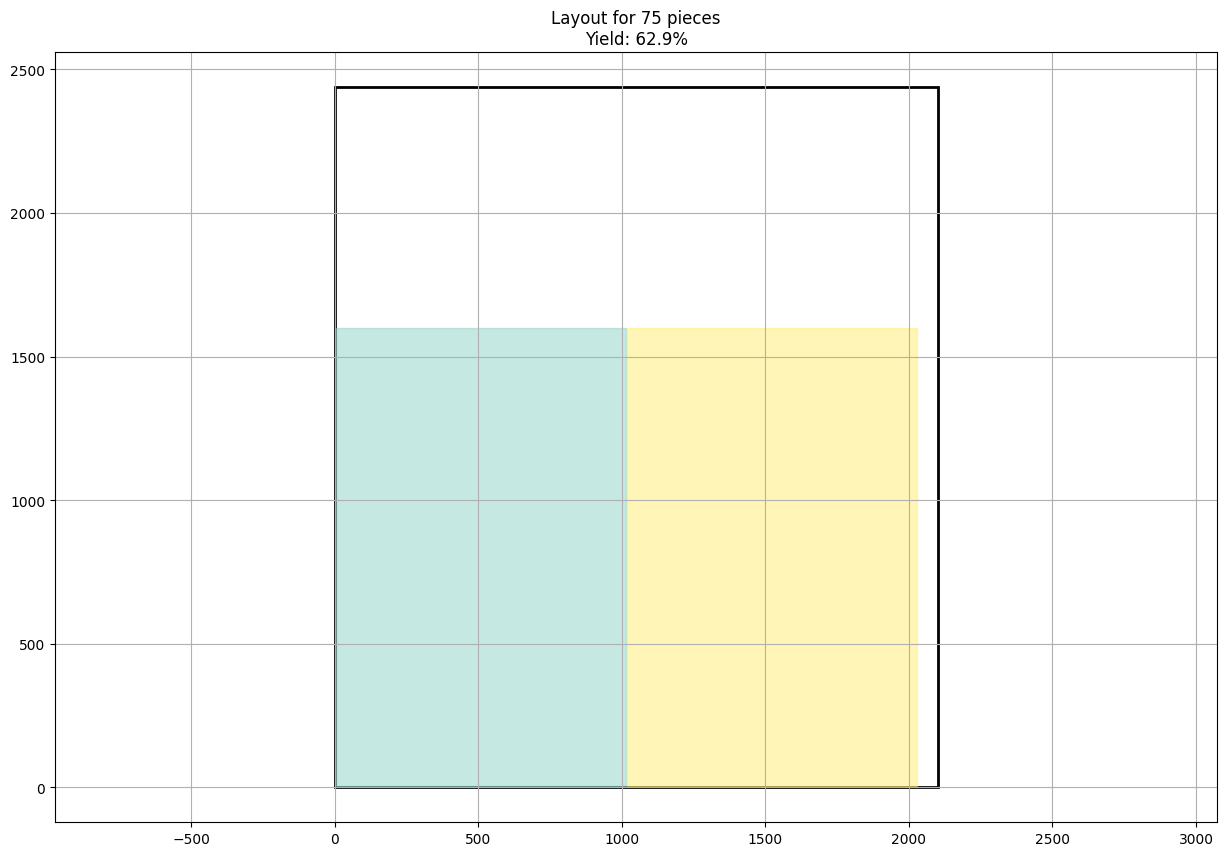

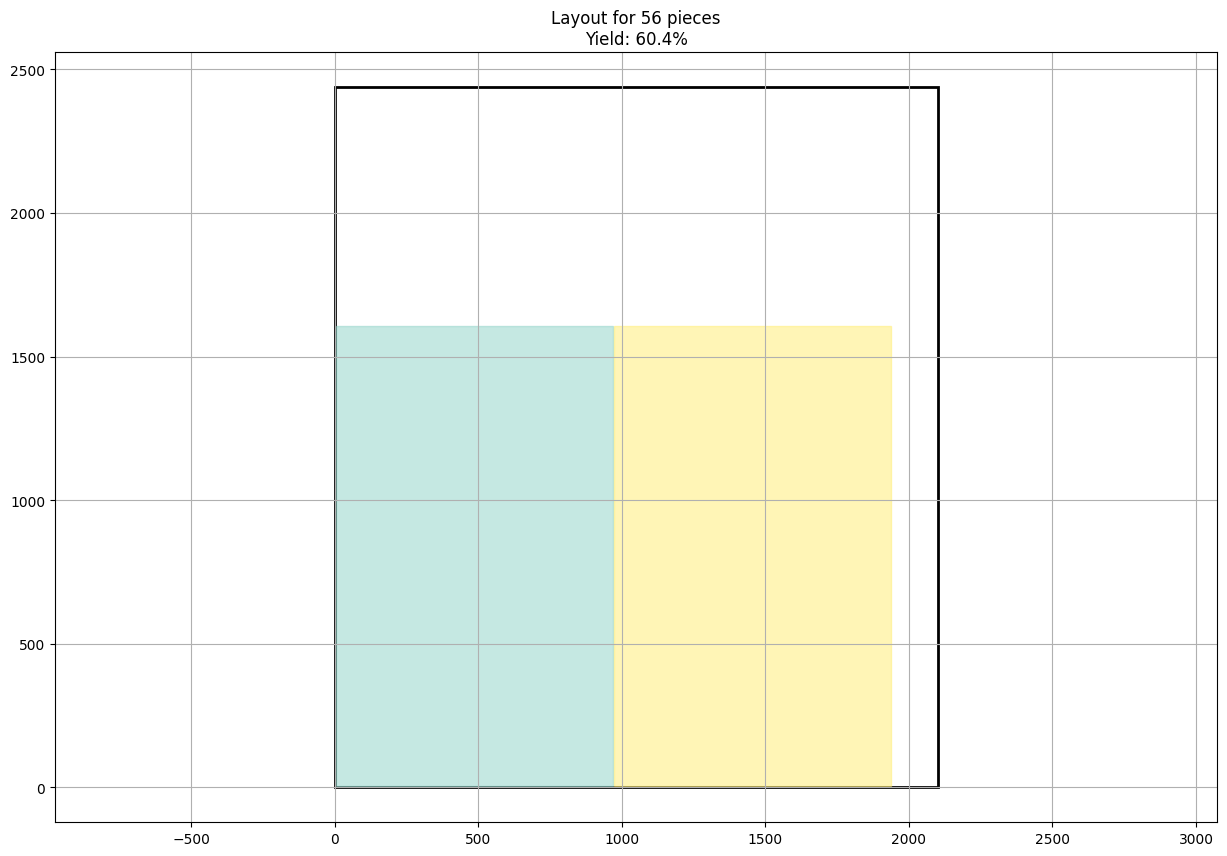

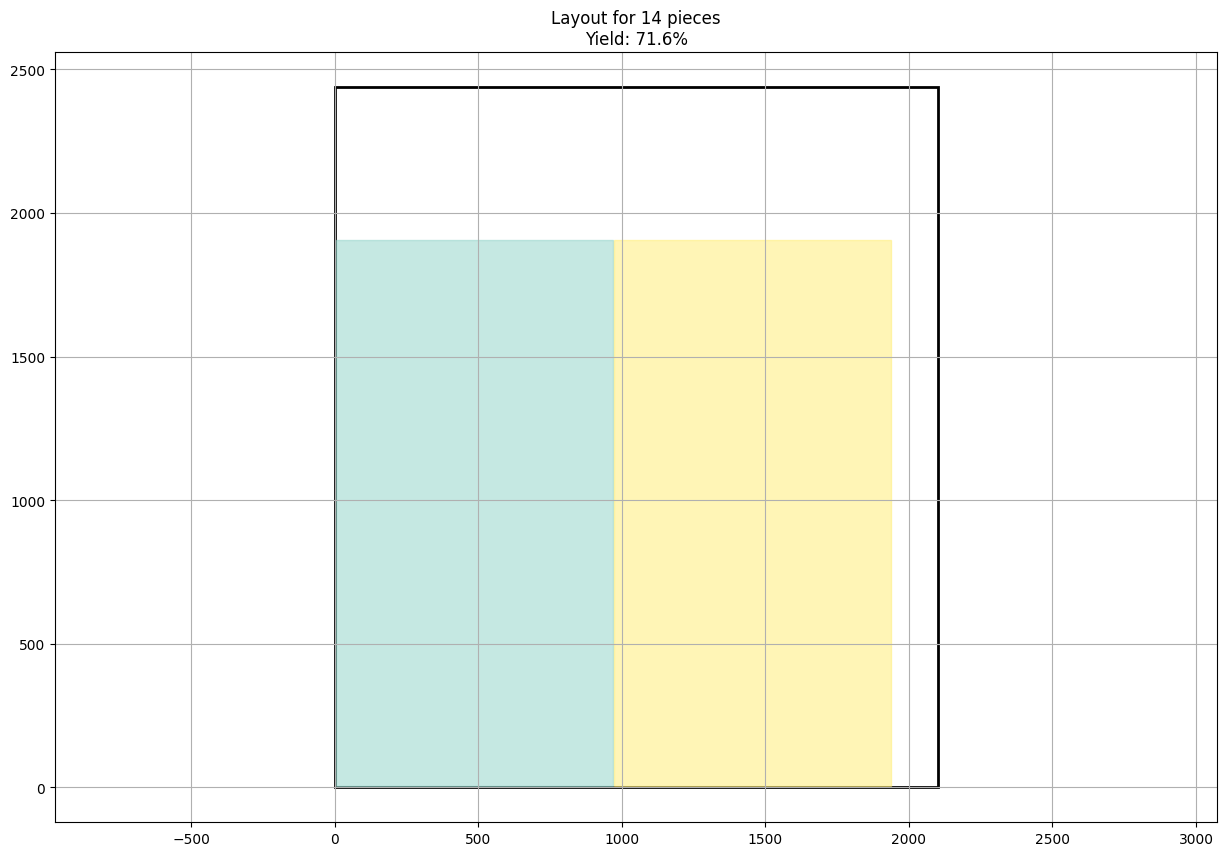

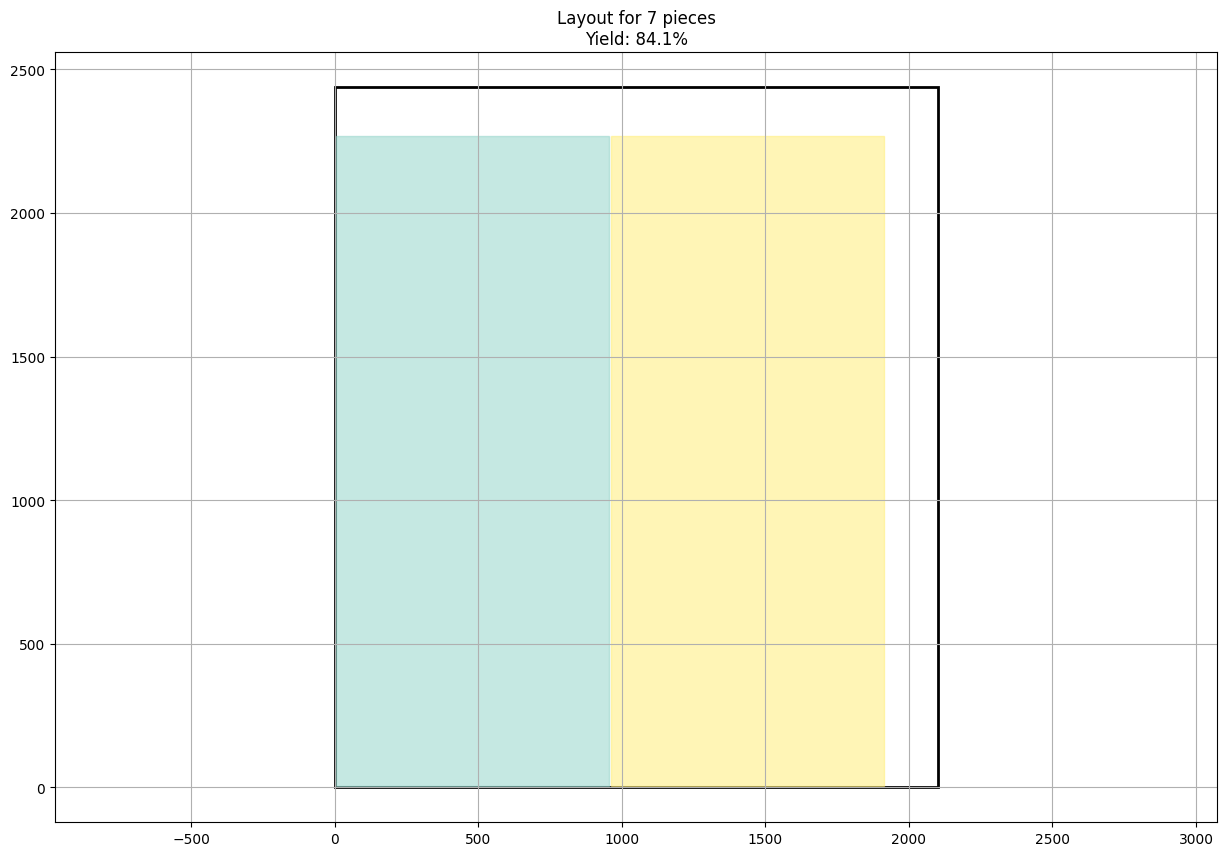

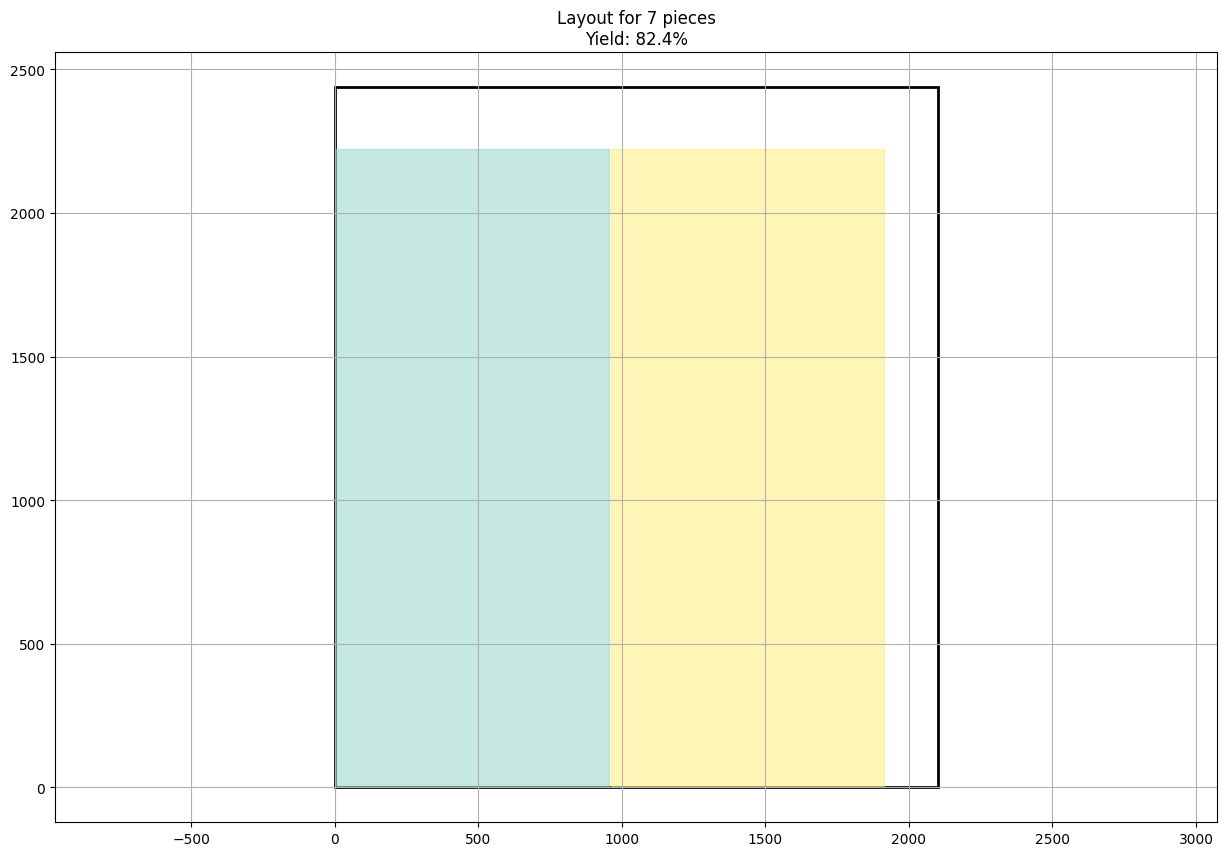

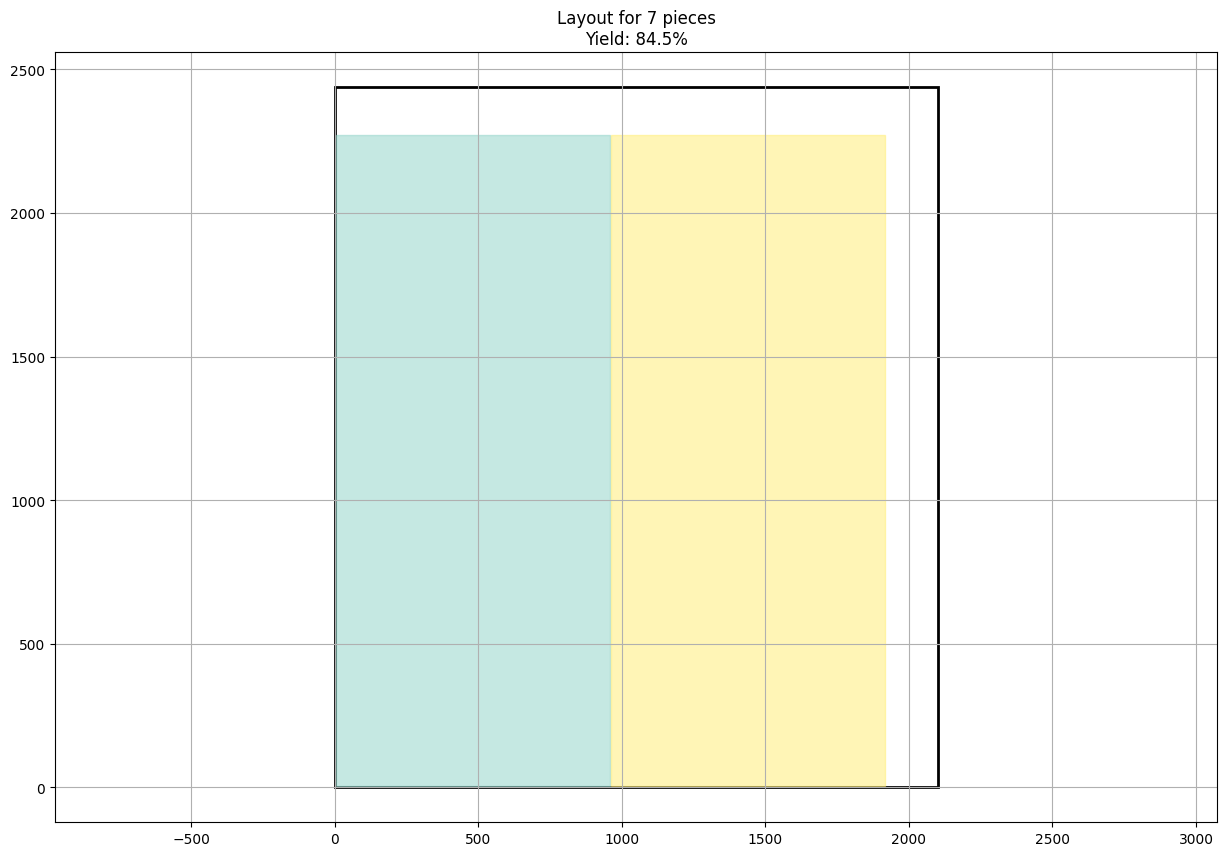

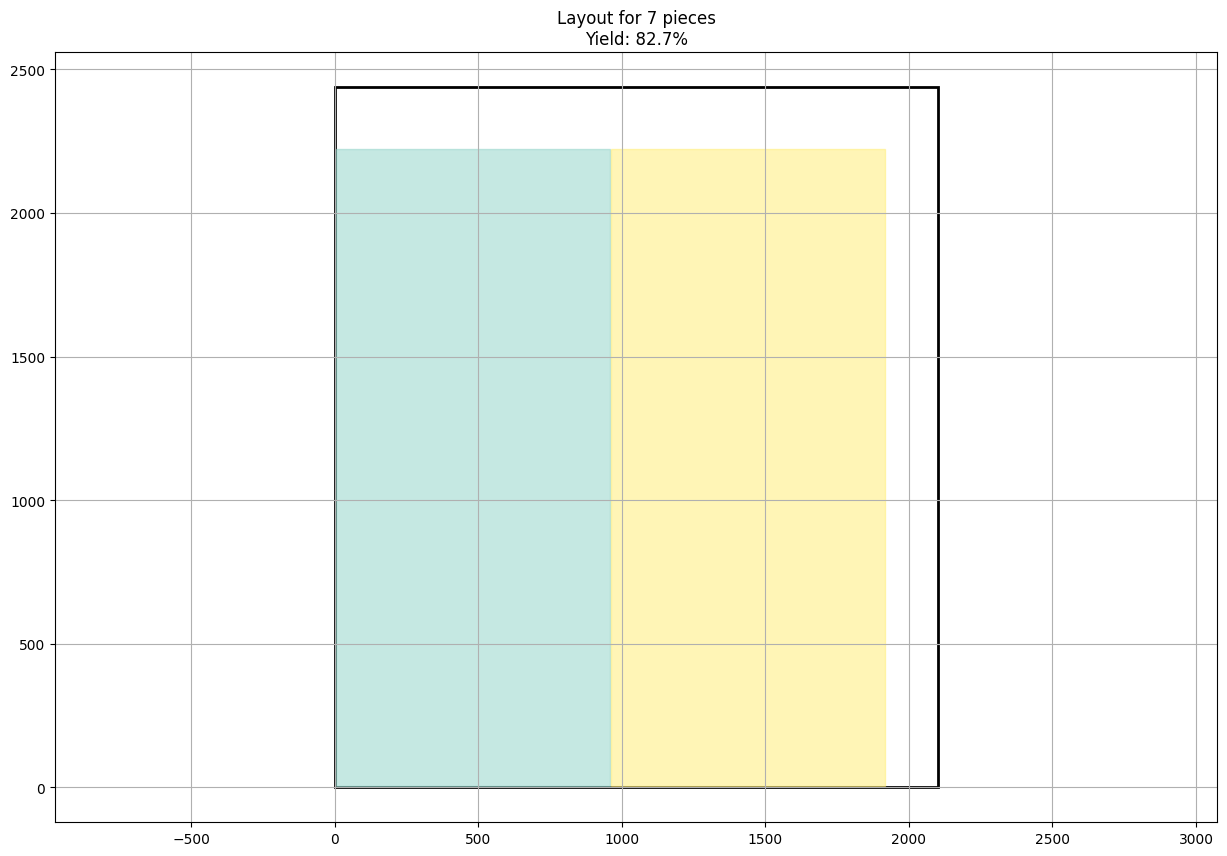

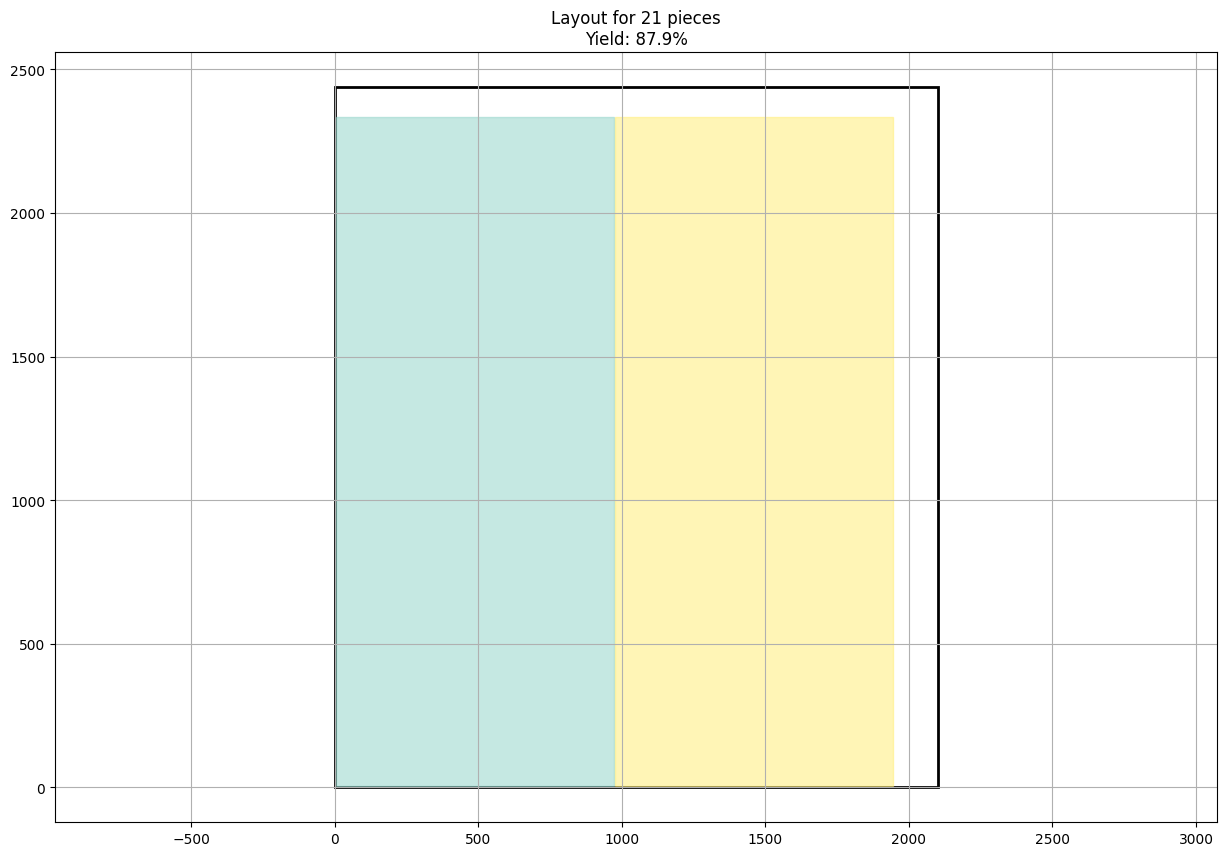

Total pieces: 260
Pieces placed: 24
Remaining pieces: 236


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple, Dict
from collections import defaultdict

# Define file paths
glass_data_file = 'data/glass_data.csv'
stock_sizes_file = 'data/glass_sheet_size.csv'
gap = 0  # Gap between parts in mm

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

def optimize_sheet(stock_size: Tuple[int, int], pieces: List[Tuple[int, int]], spacing: int = 5):
    stock_width, stock_height = stock_size
    placements = []
    current_x = spacing
    current_y = spacing
    row_height = 0
    
    # Sort pieces by height descending
    pieces = sorted(pieces, key=lambda x: (x[1], x[0]), reverse=True)
    
    for piece in pieces:
        width, height = piece
        
        # Check if piece fits in current row with spacing
        if current_x + width + spacing > stock_width:
            # Move to next row
            current_x = spacing
            current_y += row_height + spacing
            row_height = 0
            
        # Check if piece fits in sheet height
        if current_y + height + spacing > stock_height:
            break
            
        # Place piece
        placements.append((current_x, current_y, width, height))
        current_x += width + spacing
        row_height = max(row_height, height)
    
    return placements

def visualize_layout(stock_size: Tuple[int, int], placements: List[Tuple[int, int, int, int]], title: str):
    plt.figure(figsize=(15, 10))
    ax = plt.gca()
    
    # Draw stock sheet
    rect = plt.Rectangle((0, 0), stock_size[0], stock_size[1], fill=False, color='black', linewidth=2)
    ax.add_patch(rect)
    
    # Draw pieces
    colors = plt.cm.Set3(np.linspace(0, 1, len(placements)))
    for (x, y, w, h), color in zip(placements, colors):
        rect = plt.Rectangle((x, y), w, h, fill=True, color=color, alpha=0.5)
        ax.add_patch(rect)
        
    plt.title(title)
    ax.set_xlim(-100, stock_size[0] + 100)
    ax.set_ylim(-100, stock_size[1] + 100)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def visualize_unique_layouts(stock_size: Tuple[int, int], pieces: List[Tuple[int, int]]):
    # Group pieces by unique configurations
    config_groups = defaultdict(list)
    
    # Create unique configuration key
    for piece in pieces:
        config_key = piece
        config_groups[config_key].append(piece)
    
    # Track total pieces and total placed
    total_pieces = len(pieces)
    total_placed = 0
    
    # Iterate through unique configurations
    for config_pieces in config_groups.values():
        # Optimize layout for this configuration
        placements = optimize_sheet(stock_size, config_pieces)
        
        # Calculate yield (fixed syntax error)
        total_piece_area = sum(w * h for (x, y, w, h) in placements)
        stock_area = stock_size[0] * stock_size[1]
        yield_pct = (total_piece_area / stock_area) * 100
        
        # Visualize with count of identical pieces
        visualize_layout(
            stock_size, 
            placements, 
            f'Layout for {len(config_pieces)} pieces\n'
            f'Yield: {yield_pct:.1f}%'
        )
        
        total_placed += len(placements)
    
    print(f"Total pieces: {total_pieces}")
    print(f"Pieces placed: {total_placed}")
    print(f"Remaining pieces: {total_pieces - total_placed}")

# Main execution
def main():
    # Load data from files
    glass_data = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Prepare pieces for optimization
    pieces = [(item['length'], item['height']) for item in glass_data for _ in range(item['qty'])]
    
    # Use the first stock size (you can modify this logic as needed)
    stock_size = (stock_sizes[0]['length'], stock_sizes[0]['width'])
    
    # Visualize layouts
    visualize_unique_layouts(stock_size, pieces)

if __name__ == "__main__":
    main()

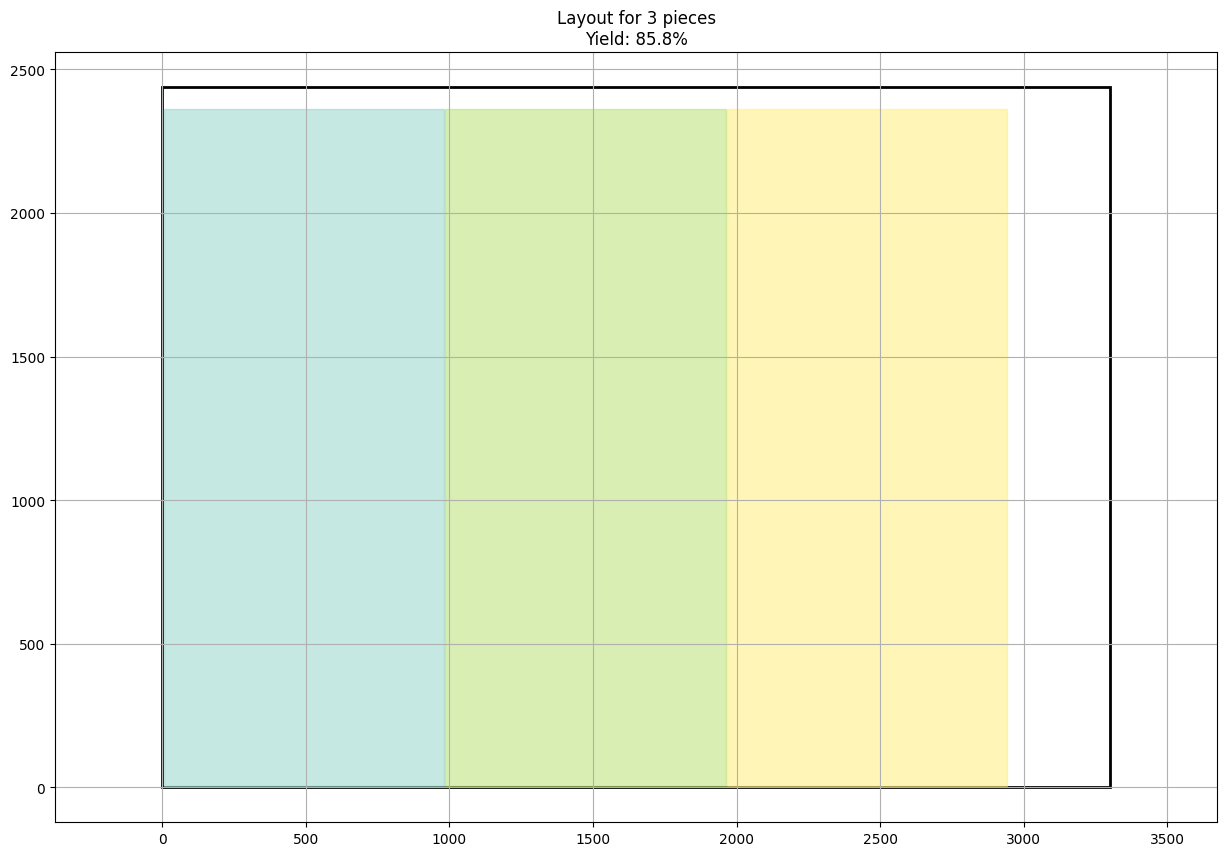

Total pieces: 260
Pieces placed: 3
Remaining pieces: 257


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple, Dict
from collections import defaultdict

# Define file paths
glass_data_file = 'data/glass_data.csv'
stock_sizes_file = 'data/glass_sheet_size.csv'
gap = 0  # Gap between parts in mm

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

def optimize_sheet(stock_size: Tuple[int, int], pieces: List[Tuple[int, int]], spacing: int = 5):
    stock_width, stock_height = stock_size
    placements = []
    current_x = spacing
    current_y = spacing
    row_height = 0
    
    # Sort pieces by area (largest first) to maximize space usage
    pieces = sorted(pieces, key=lambda x: x[0] * x[1], reverse=True)
    unplaced_pieces = []
    
    for piece in pieces:
        width, height = piece
        
        # Try both orientations
        orientations = [(width, height), (height, width)]
        
        placed = False
        for w, h in orientations:
            # Check if piece fits in current row
            if current_x + w + spacing <= stock_width:
                # Check if piece fits in sheet height
                if current_y + h + spacing <= stock_height:
                    placements.append((current_x, current_y, w, h))
                    current_x += w + spacing
                    row_height = max(row_height, h)
                    placed = True
                    break
            
            # If not placed, move to next row
            if not placed:
                current_x = spacing
                current_y += row_height + spacing
                row_height = 0
                
                # Check if piece fits in new row and sheet height
                if current_x + w + spacing <= stock_width and current_y + h + spacing <= stock_height:
                    placements.append((current_x, current_y, w, h))
                    current_x += w + spacing
                    row_height = max(row_height, h)
                    placed = True
                    break
        
        # If piece cannot be placed, add to unplaced pieces
        if not placed:
            unplaced_pieces.append(piece)
    
    return placements, unplaced_pieces

def visualize_unique_layouts(stock_sizes: List[Tuple[int, int]], pieces: List[Tuple[int, int]]):
    # Convert single stock size to a list if it's not already a list
    if isinstance(stock_sizes, tuple):
        stock_sizes = [stock_sizes]
    
    # Sort stock sizes by area (largest first)
    sorted_stock_sizes = sorted(stock_sizes, key=lambda x: x[0] * x[1], reverse=True)
    
    # Track total pieces and total placed
    total_pieces = len(pieces)
    total_placed = 0
    
    # Remaining pieces to place
    remaining_pieces = pieces.copy()
    
    # Try different stock sizes
    while remaining_pieces:
        # Break if no more stock sizes
        if not sorted_stock_sizes:
            break
        
        # Get current stock size
        current_stock_size = sorted_stock_sizes.pop(0)
        
        # Optimize layout for this configuration
        placements, unplaced = optimize_sheet(current_stock_size, remaining_pieces)
        
        # Calculate yield
        total_piece_area = sum(w * h for (x, y, w, h) in placements)
        stock_area = current_stock_size[0] * current_stock_size[1]
        yield_pct = (total_piece_area / stock_area) * 100
        
        # Visualize with count of identical pieces
        visualize_layout(
            current_stock_size, 
            placements, 
            f'Layout for {len(placements)} pieces\n'
            f'Yield: {yield_pct:.1f}%'
        )
        
        # Update remaining pieces
        remaining_pieces = unplaced
        total_placed += len(placements)
    
    print(f"Total pieces: {total_pieces}")
    print(f"Pieces placed: {total_placed}")
    print(f"Remaining pieces: {len(remaining_pieces)}")

# Main execution
def main():
    # Load data from files
    glass_data = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Prepare pieces for optimization
    pieces = [(item['length'], item['height']) for item in glass_data for _ in range(item['qty'])]
    
    # Use the first stock size (you can modify this logic as needed)
    # stock_size = (stock_sizes[0]['length'], stock_sizes[0]['width'])
    
    # Visualize layouts
    visualize_unique_layouts(stock_size, pieces)

if __name__ == "__main__":
    main()

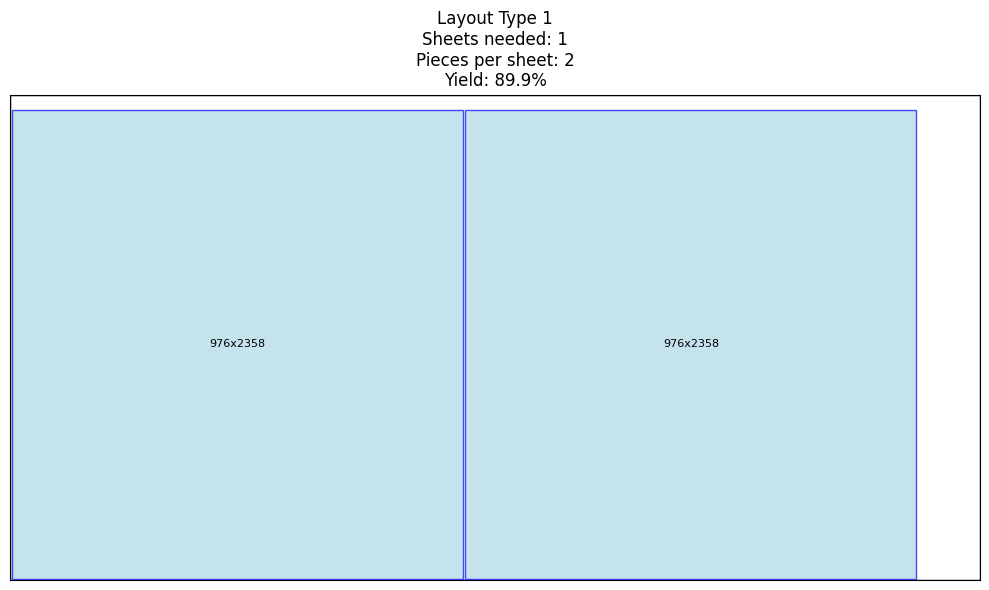

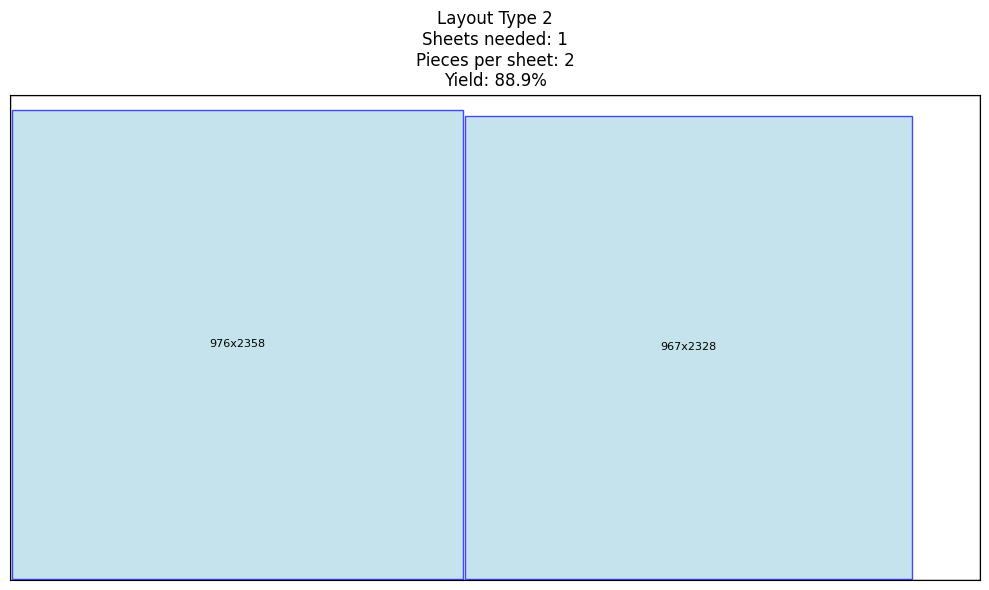

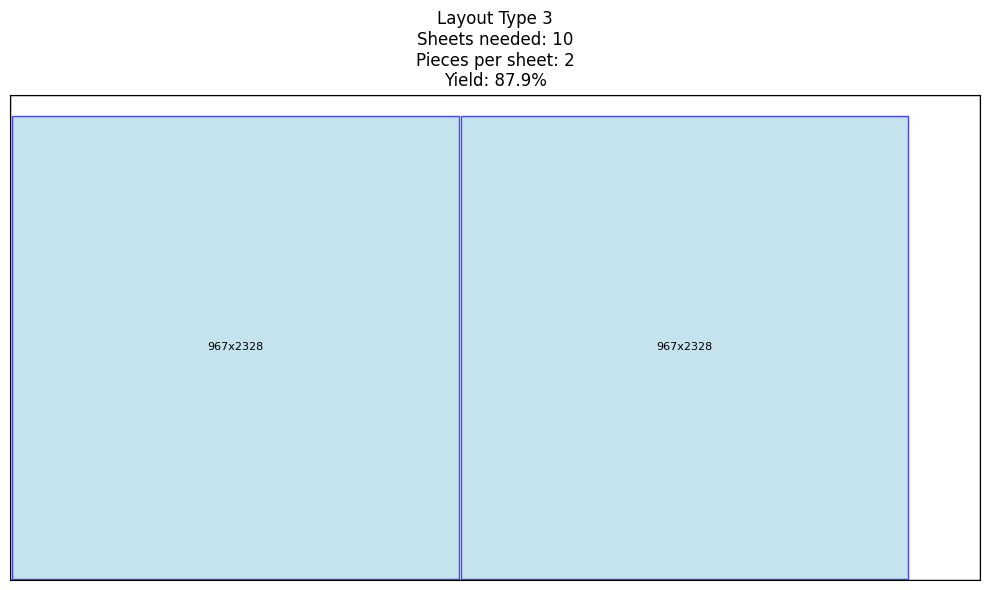

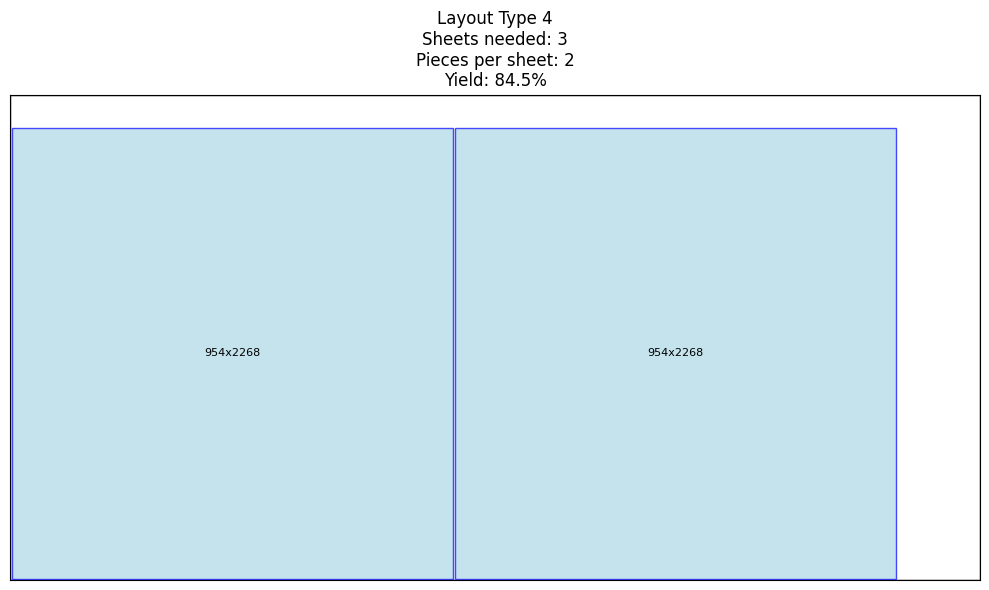

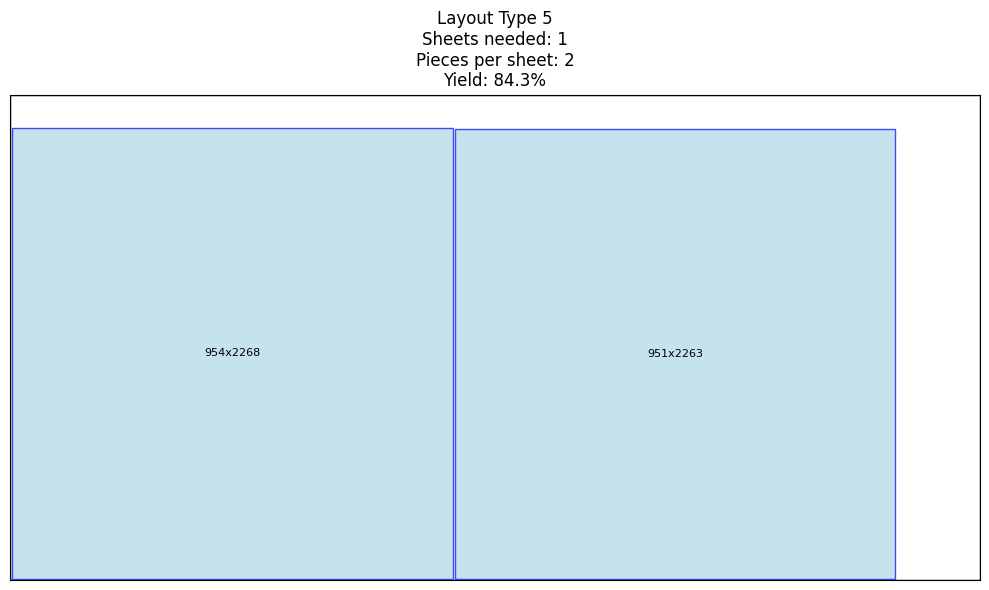

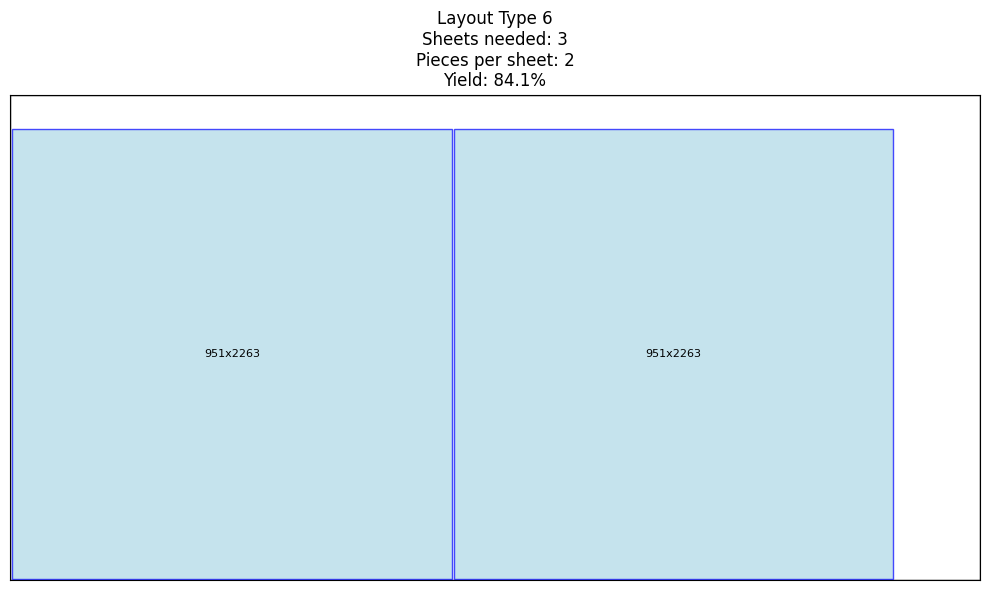

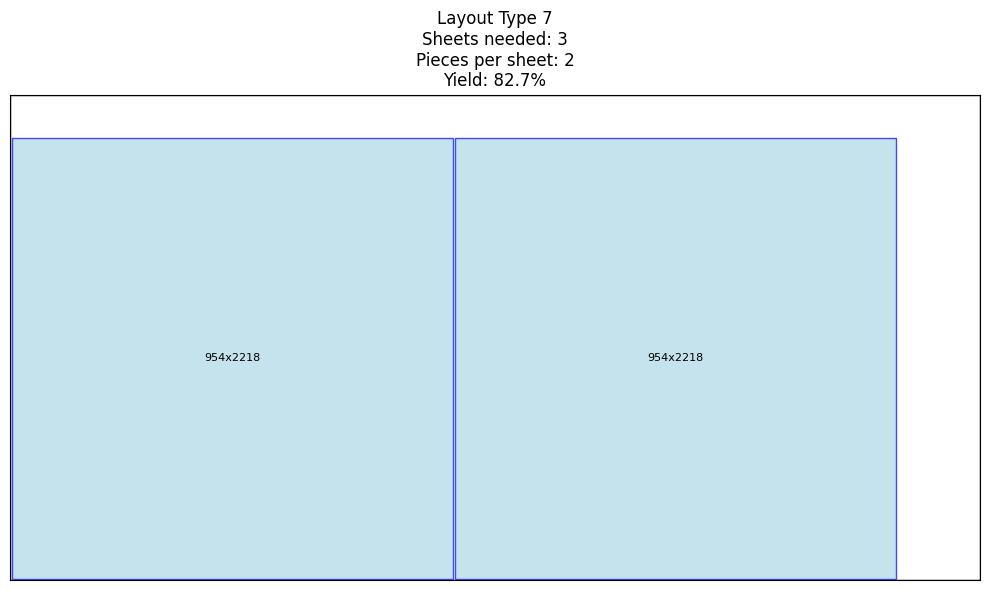

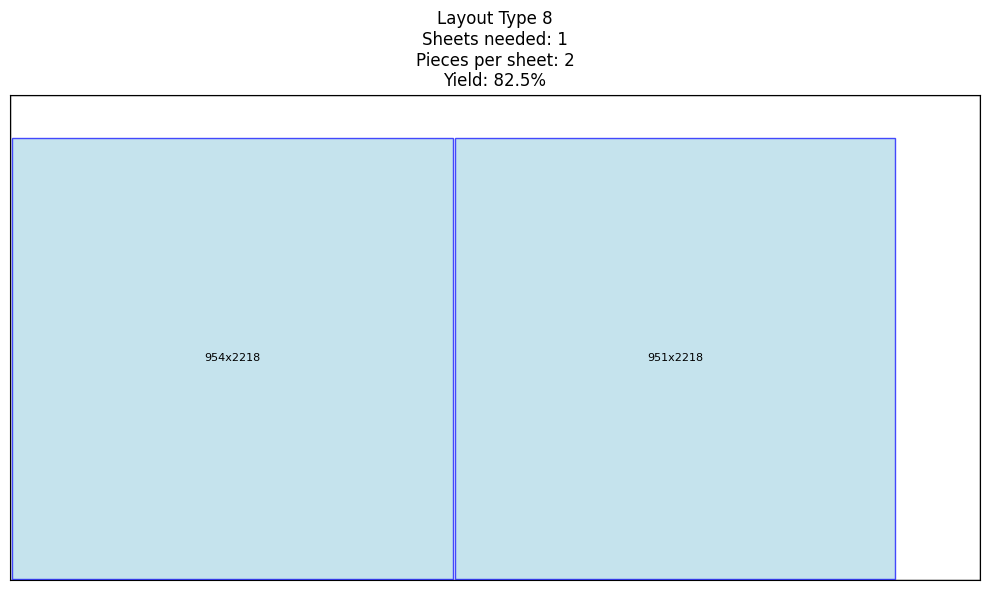

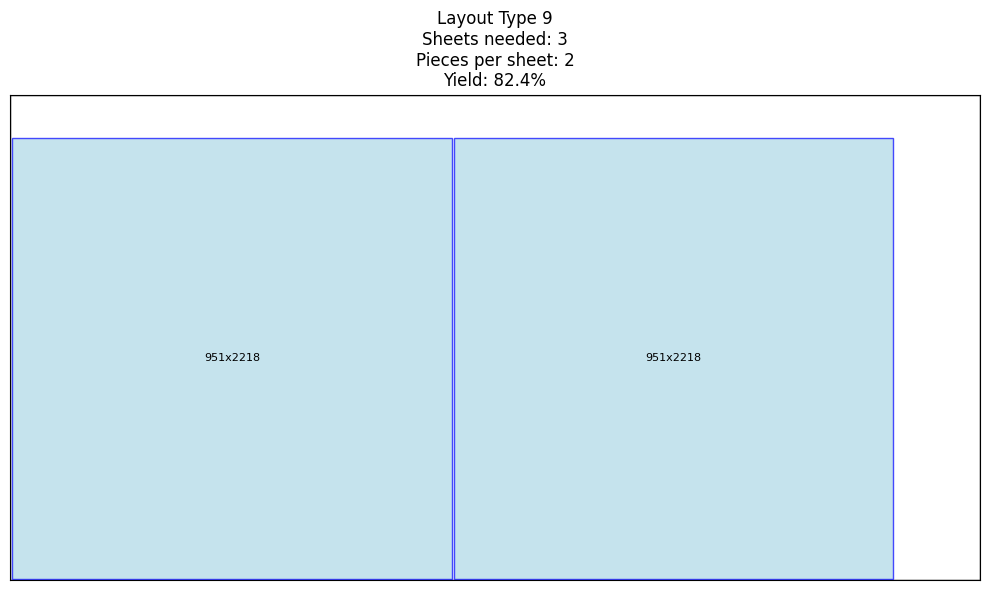

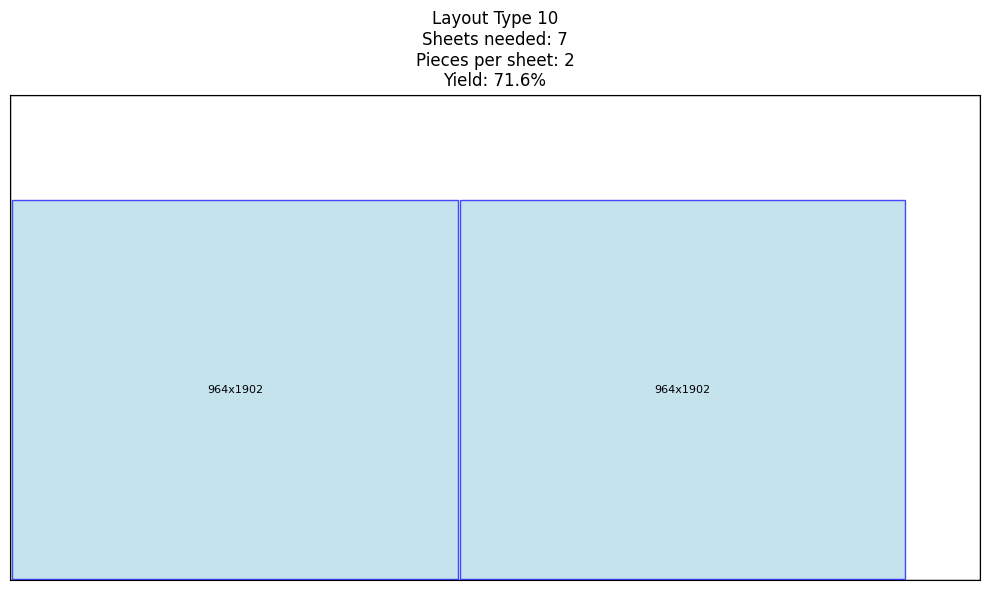

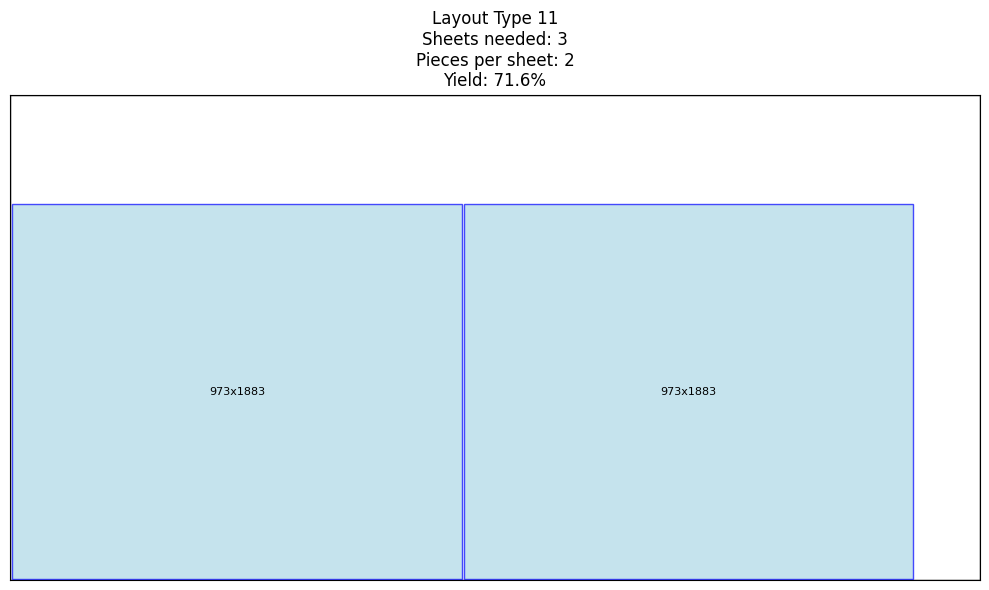

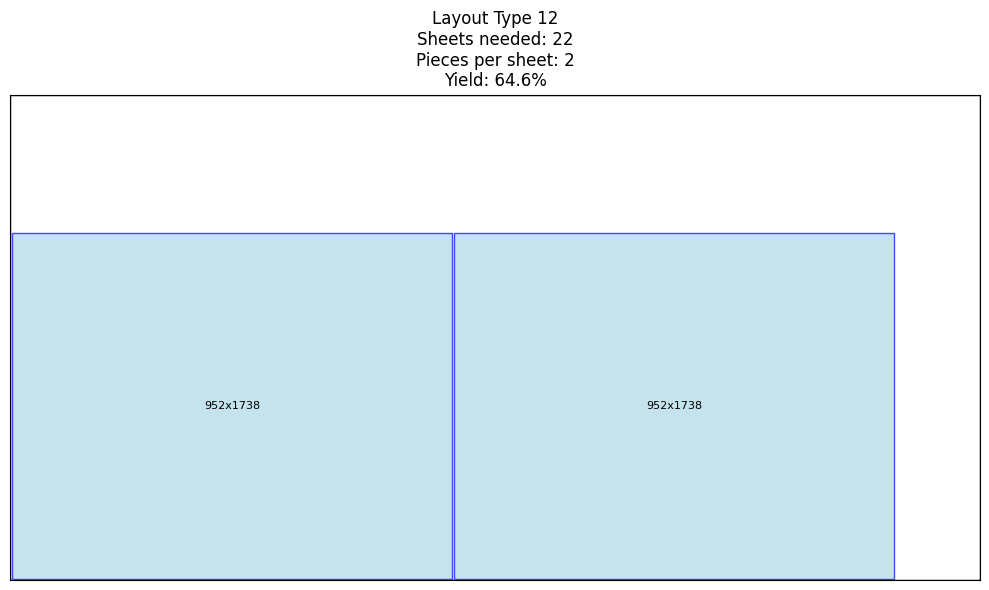

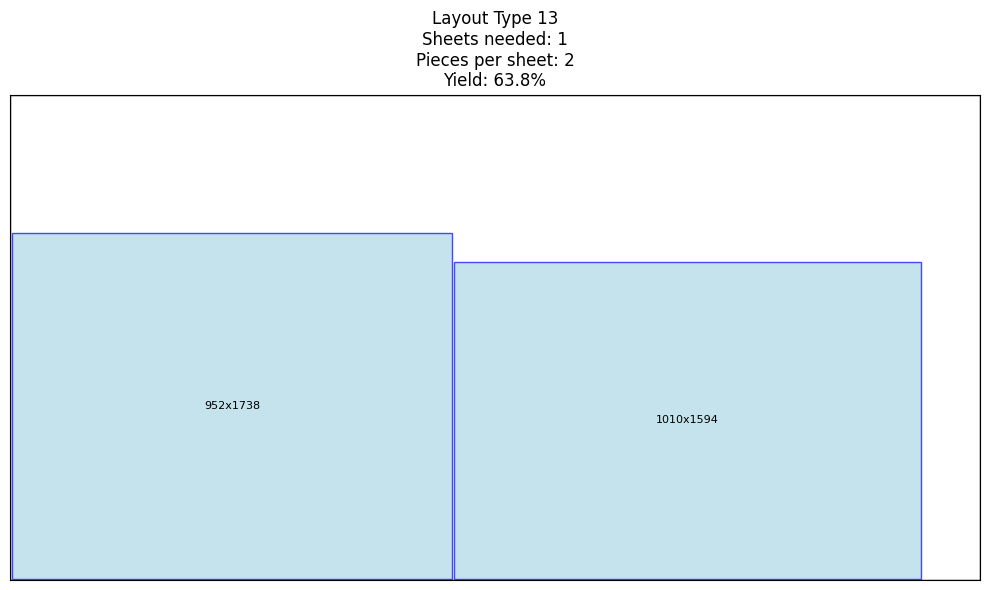

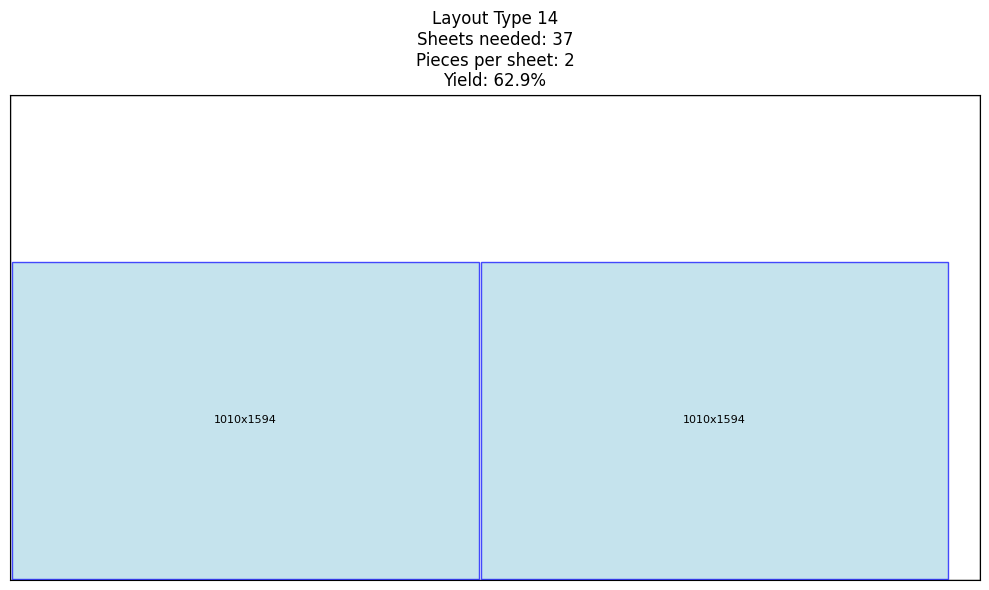

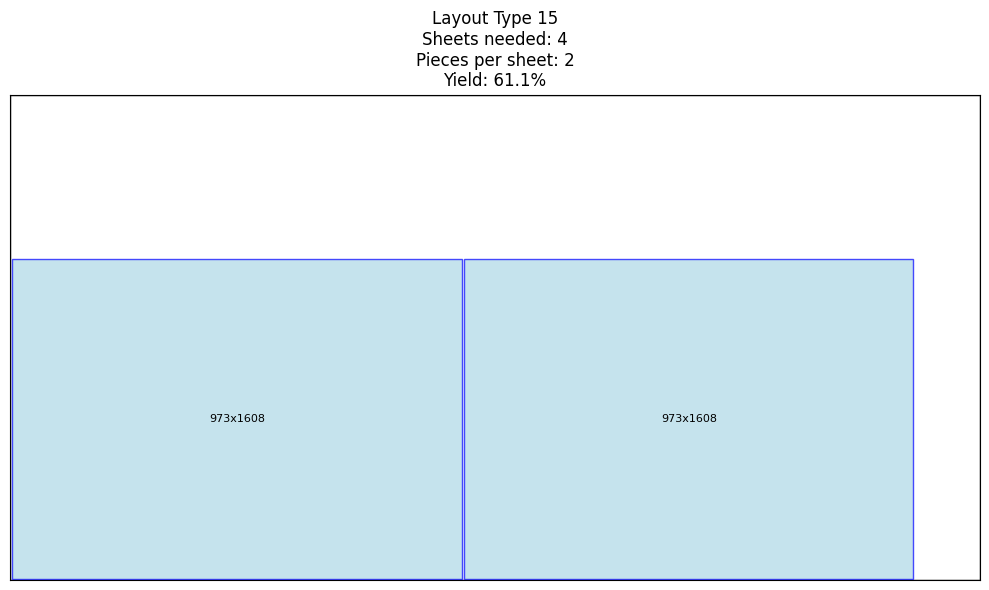

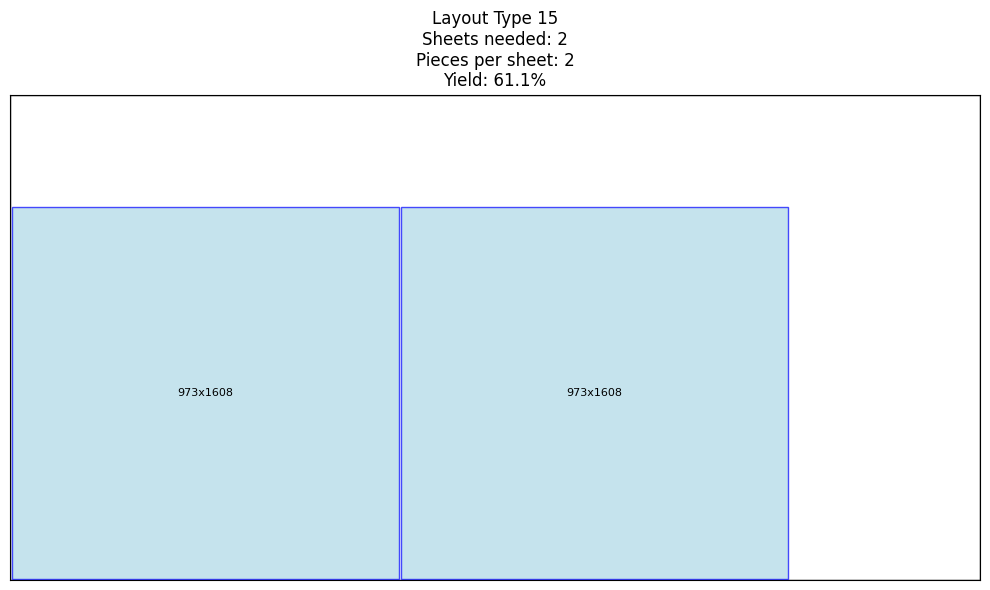

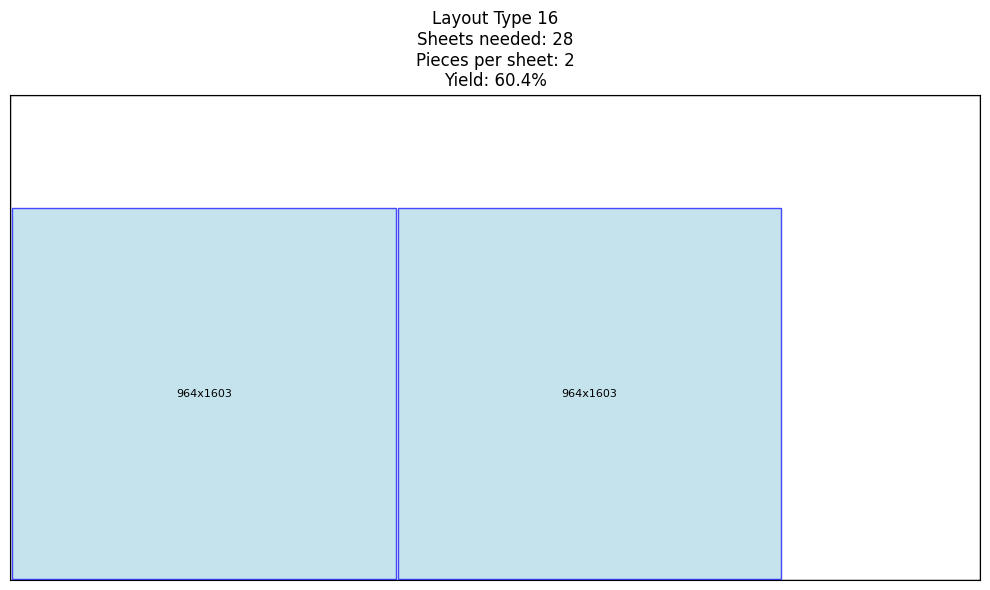

Total pieces: 260
Pieces placed: 260
Unique layout types: 16
Total sheets used: 130
Average Yield: 67.8%


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple, Dict
from collections import defaultdict

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

def optimize_sheet(stock_size: Tuple[int, int], pieces: List[Tuple[int, int]], spacing: int = 5):
    stock_width, stock_height = stock_size
    placements = []
    current_x = spacing
    current_y = spacing
    row_height = 0
    
    # Sort pieces by area (largest first) to maximize space usage
    pieces = sorted(pieces, key=lambda x: x[0] * x[1], reverse=True)
    unplaced_pieces = []
    
    for piece in pieces:
        width, height = piece
        
        # Try both orientations
        orientations = [(width, height), (height, width)]
        
        placed = False
        for w, h in orientations:
            # Check if piece fits in current row
            if current_x + w + spacing <= stock_width:
                # Check if piece fits in sheet height
                if current_y + h + spacing <= stock_height:
                    placements.append((current_x, current_y, w, h))
                    current_x += w + spacing
                    row_height = max(row_height, h)
                    placed = True
                    break
            
            # If not placed, move to next row
            if not placed:
                current_x = spacing
                current_y += row_height + spacing
                row_height = 0
                
                # Check if piece fits in new row and sheet height
                if current_x + w + spacing <= stock_width and current_y + h + spacing <= stock_height:
                    placements.append((current_x, current_y, w, h))
                    current_x += w + spacing
                    row_height = max(row_height, h)
                    placed = True
                    break
        
        # If piece cannot be placed, add to unplaced pieces
        if not placed:
            unplaced_pieces.append(piece)
    
    return placements, unplaced_pieces

def visualize_layout(stock_size: Tuple[int, int], placements: List[Tuple[int, int]], title: str):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    # Draw stock sheet
    plt.gca().add_patch(plt.Rectangle((0, 0), stock_size[0], stock_size[1], 
                                       fill=False, edgecolor='black'))
    
    # Draw pieces
    for x, y, w, h in placements:
        rect = plt.Rectangle((x, y), w, h, 
                              facecolor='lightblue', 
                              edgecolor='blue', 
                              alpha=0.7)
        plt.gca().add_patch(rect)
        
        # Annotate piece dimensions
        plt.text(x + w/2, y + h/2, f'{w}x{h}', 
                 ha='center', va='center', fontsize=8)
    
    # Remove grid and ticks
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Set axis limits to stock sheet size
    plt.xlim(0, stock_size[0])
    plt.ylim(0, stock_size[1])
    
    plt.tight_layout()
    plt.show()

# def visualize_layout(stock_size: Tuple[int, int], placements: List[Tuple[int, int]], title: str):
#     plt.figure(figsize=(12, 8))
#     plt.title(title)
    
#     # Draw stock sheet
#     plt.gca().add_patch(plt.Rectangle((0, 0), stock_size[0], stock_size[1], 
#                                     fill=False, edgecolor='black'))
    
#     # Add stock sheet dimensions outside
#     plt.text(stock_size[0]/2, -30, f'{stock_size[0]}mm', ha='center')
#     plt.text(-30, stock_size[1]/2, f'{stock_size[1]}mm', va='center', rotation=90)
    
#     # Draw pieces with optimized spacing
#     for x, y, w, h in placements:
#         rect = plt.Rectangle((x, y), w, h, 
#                            facecolor='lightblue', 
#                            edgecolor='blue', 
#                            alpha=0.7)
#         plt.gca().add_patch(rect)
#         plt.text(x + w/2, y + h/2, f'{w}x{h}', 
#                 ha='center', va='center', fontsize=8)
    
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
    
#     # Adjust margins to show outside measurements
#     plt.margins(x=0.1, y=0.1)
#     plt.tight_layout()
#     plt.show()

def visualize_unique_layouts(stock_sizes: List[Dict], pieces: List[Tuple[int, int]]):
    # Group pieces by dimensions and count
    piece_inventory = defaultdict(int)
    for piece in pieces:
        piece_inventory[piece] += 1
    
    total_pieces = len(pieces)
    total_placed = 0
    total_yield = 0
    layout_groups = defaultdict(int)
    remaining_inventory = piece_inventory.copy()
    
    # Process each stock size
    for stock in stock_sizes:
        stock_size = (stock['length'], stock['width'])
        available_sheets = stock['qty']
        
        while available_sheets > 0 and any(remaining_inventory.values()):
            current_pieces = []
            for piece, count in remaining_inventory.items():
                current_pieces.extend([piece] * count)
            
            placements, unplaced = optimize_sheet(stock_size, current_pieces)
            if not placements:
                break
                
            # Count unplaced pieces to determine how many were used
            unplaced_count = defaultdict(int)
            for piece in unplaced:
                unplaced_count[piece] += 1
            
            # Calculate pieces used in this layout
            pieces_used = {}
            for piece in current_pieces:
                if piece not in pieces_used:
                    total_count = remaining_inventory[piece]
                    unused_count = unplaced_count[piece]
                    pieces_used[piece] = total_count - unused_count
            
            # Calculate max sheets needed for this layout
            max_sheets = min(
                available_sheets,
                min(count // pieces_used.get(piece, 1) 
                    for piece, count in remaining_inventory.items() 
                    if pieces_used.get(piece, 0) > 0)
            )
            
            if max_sheets > 0:
                # Calculate yield
                yield_pct = (sum(w * h for (x, y, w, h) in placements) / 
                            (stock_size[0] * stock_size[1])) * 100
                
                # Update tracking
                layout_key = tuple(sorted(placements))
                layout_groups[layout_key] += max_sheets
                total_yield += yield_pct * max_sheets
                
                # Update remaining inventory
                for piece, used_count in pieces_used.items():
                    remaining_inventory[piece] -= used_count * max_sheets
                
                # Update total placed and available sheets
                total_placed += sum(pieces_used.values()) * max_sheets
                available_sheets -= max_sheets
                
                # Visualize layout
                visualize_layout(
                    stock_size,
                    placements,
                    f'Layout Type {len(layout_groups)}\n'
                    f'Sheets needed: {max_sheets}\n'
                    f'Pieces per sheet: {len(placements)}\n'
                    f'Yield: {yield_pct:.1f}%'
                )
    
    total_sheets = sum(layout_groups.values())
    print(f"Total pieces: {total_pieces}")
    print(f"Pieces placed: {total_placed}")
    print(f"Unique layout types: {len(layout_groups)}")
    print(f"Total sheets used: {total_sheets}")
    print(f"Average Yield: {total_yield/total_sheets:.1f}%" if total_sheets > 0 else "No layouts created")

def main():
    # Load data from files
    glass_data = load_glass_data('data/glass_data.csv')
    stock_sizes = load_stock_sizes('data/glass_sheet_size.csv')
    
    # Prepare pieces for optimization
    pieces = [(item['length'], item['height']) for item in glass_data for _ in range(item['qty'])]
    
    # Visualize layouts
    visualize_unique_layouts(stock_sizes, pieces)

if __name__ == "__main__":
    main()

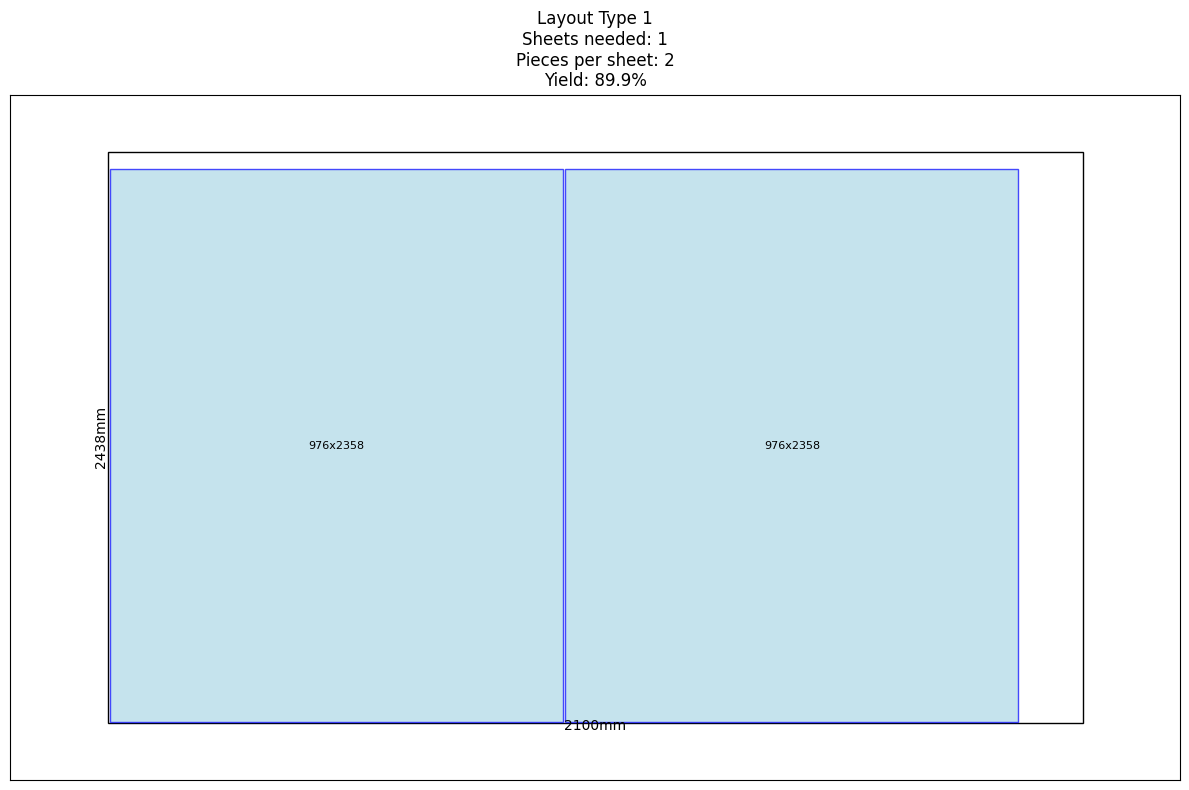

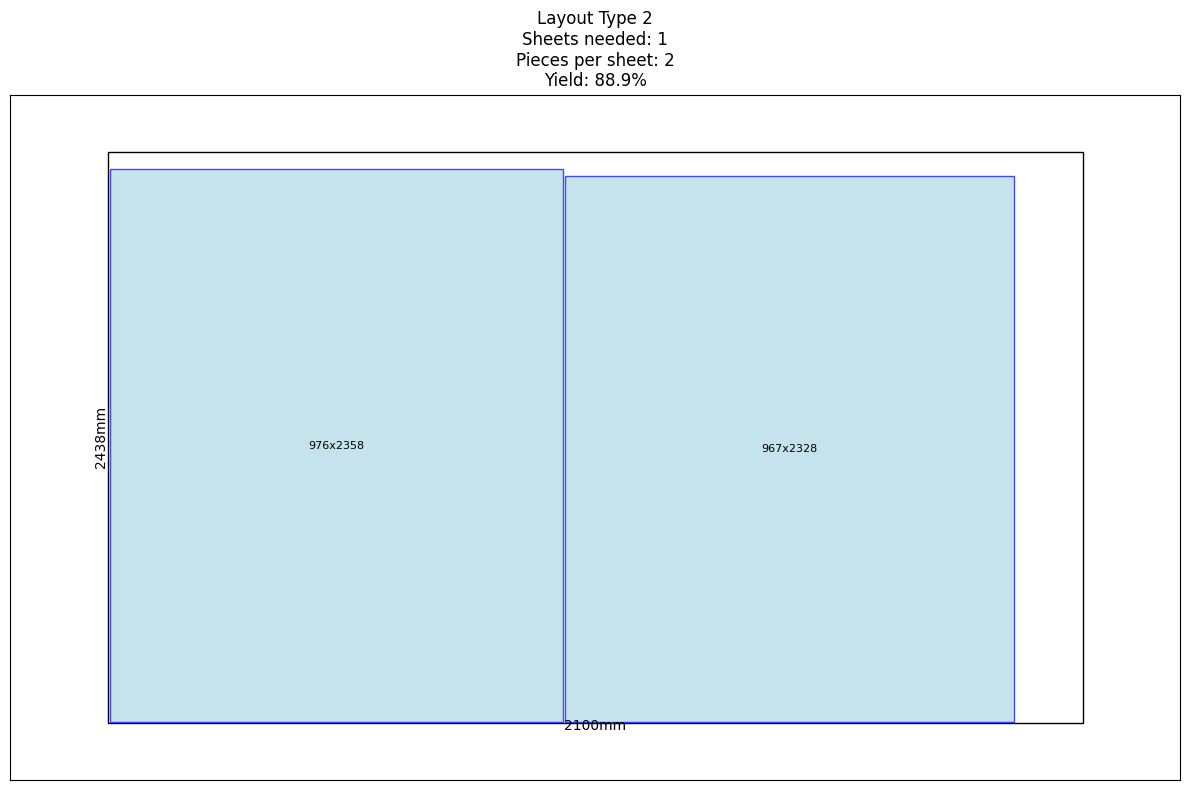

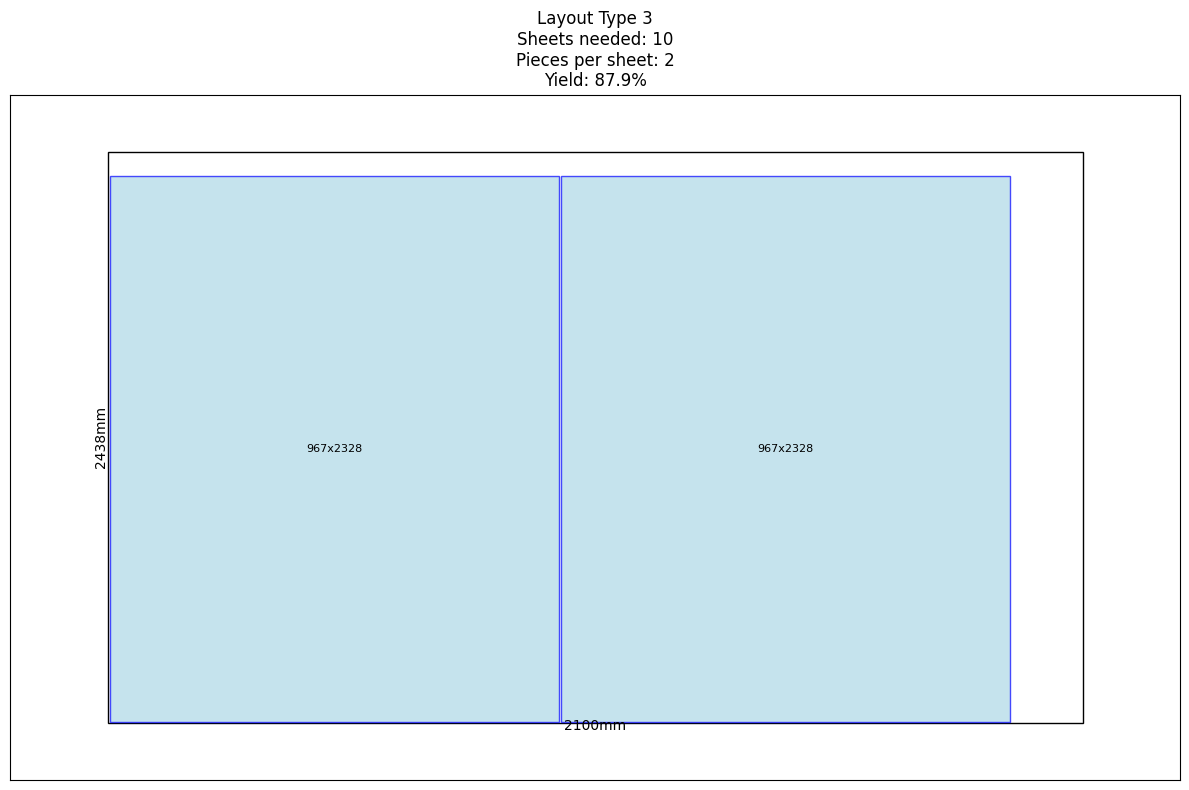

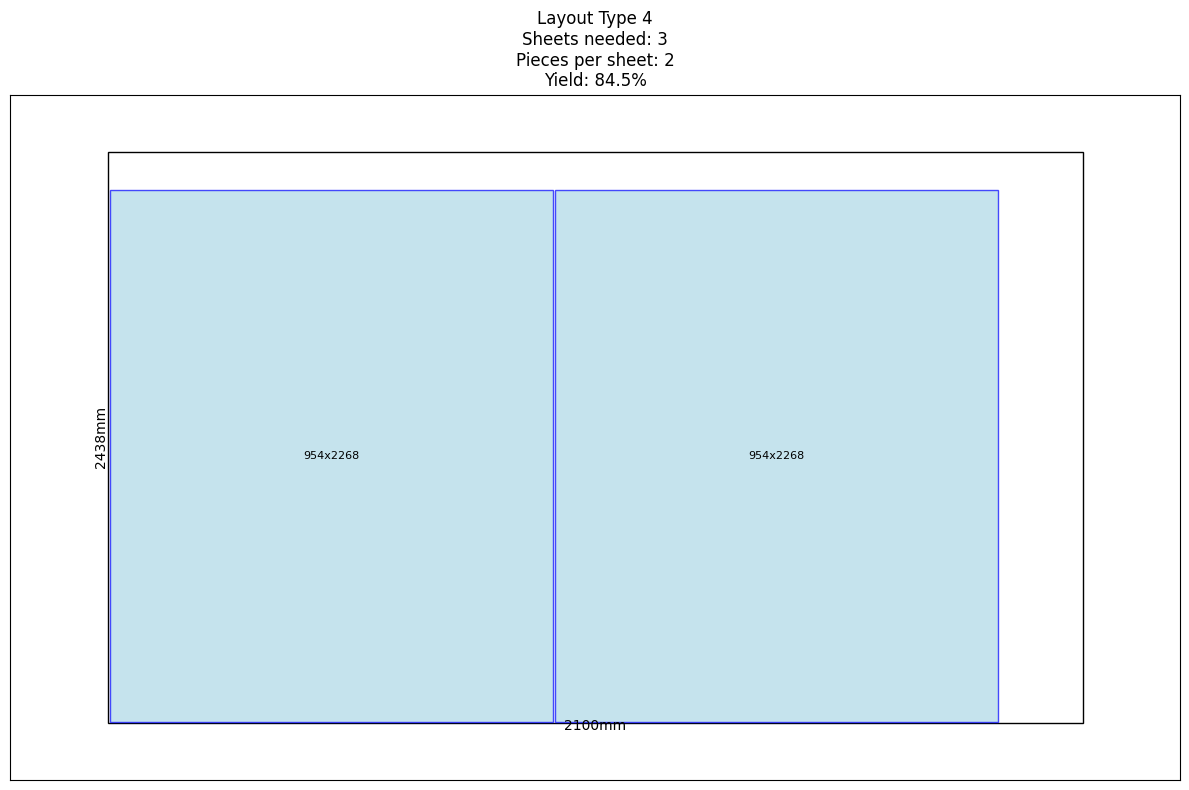

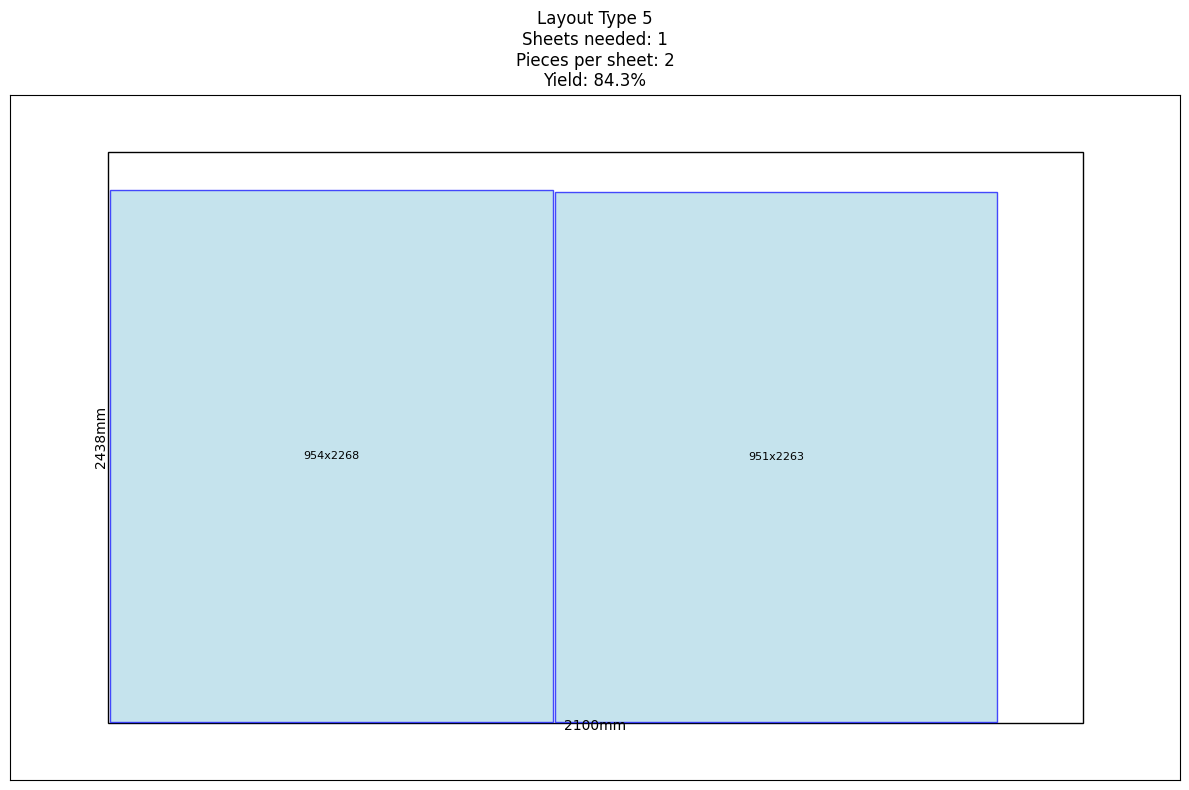

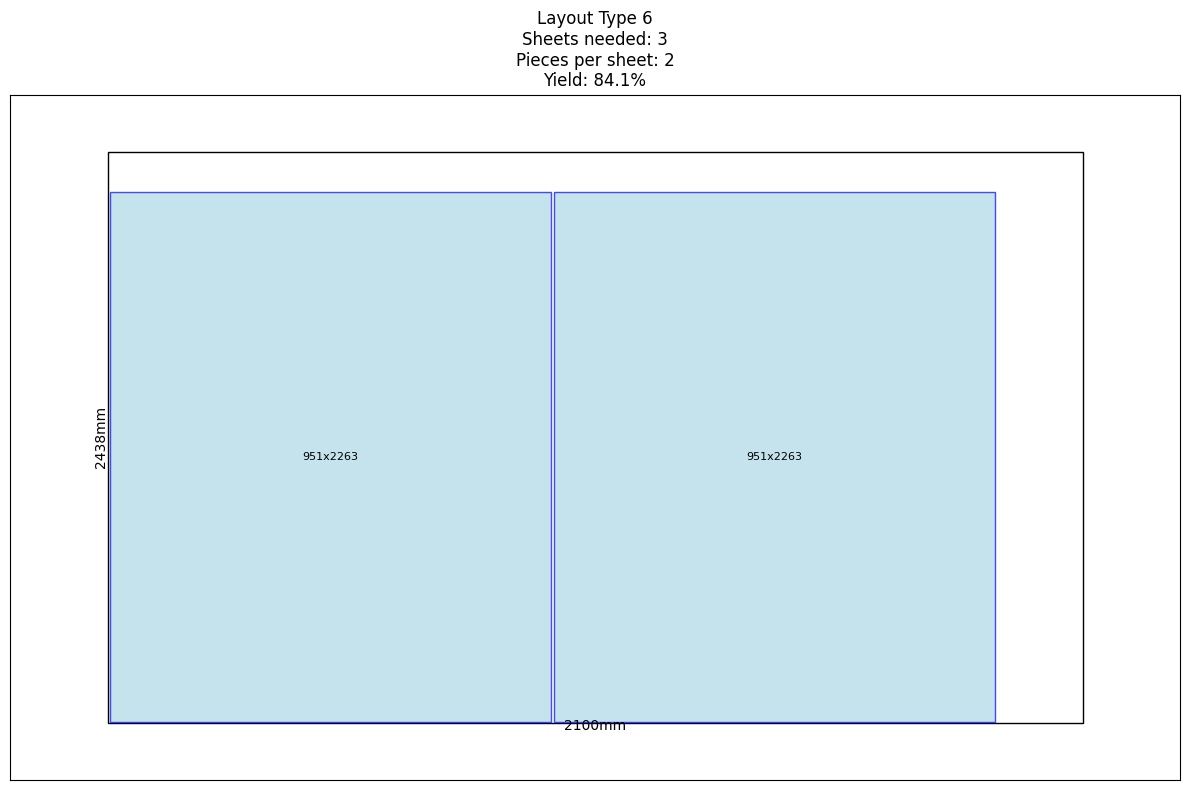

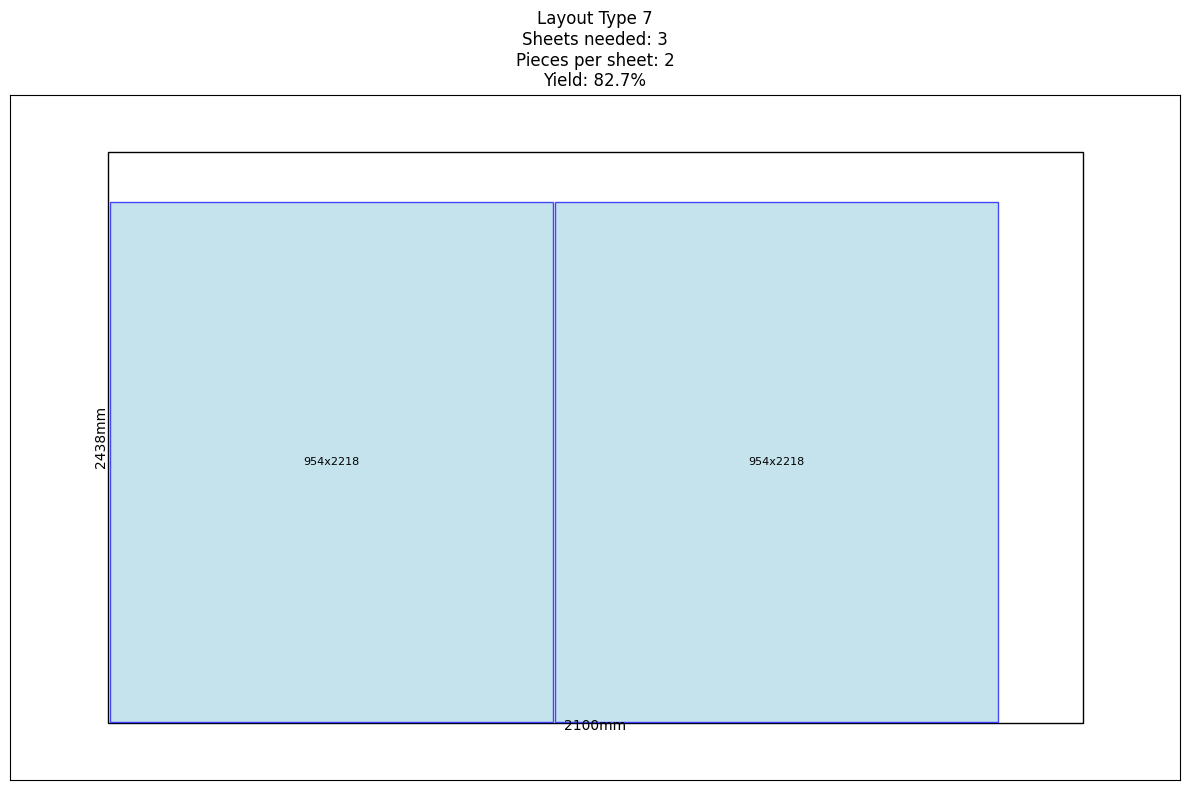

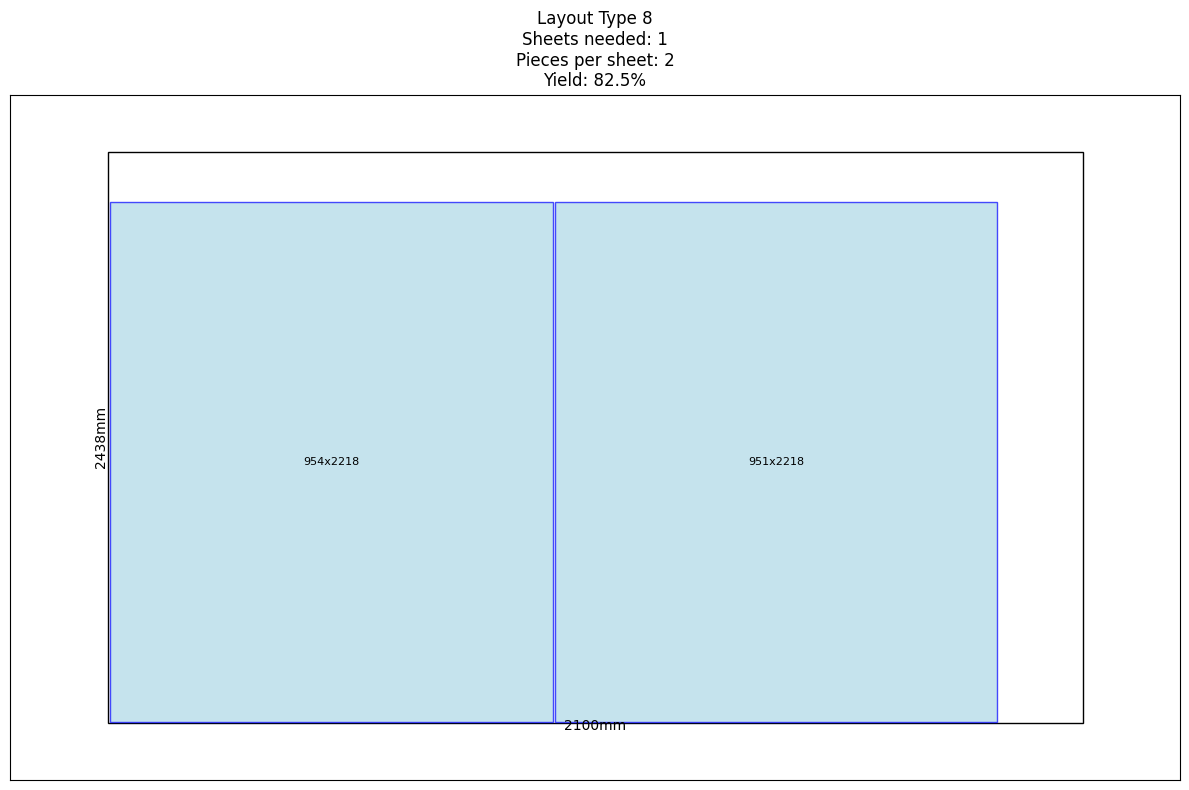

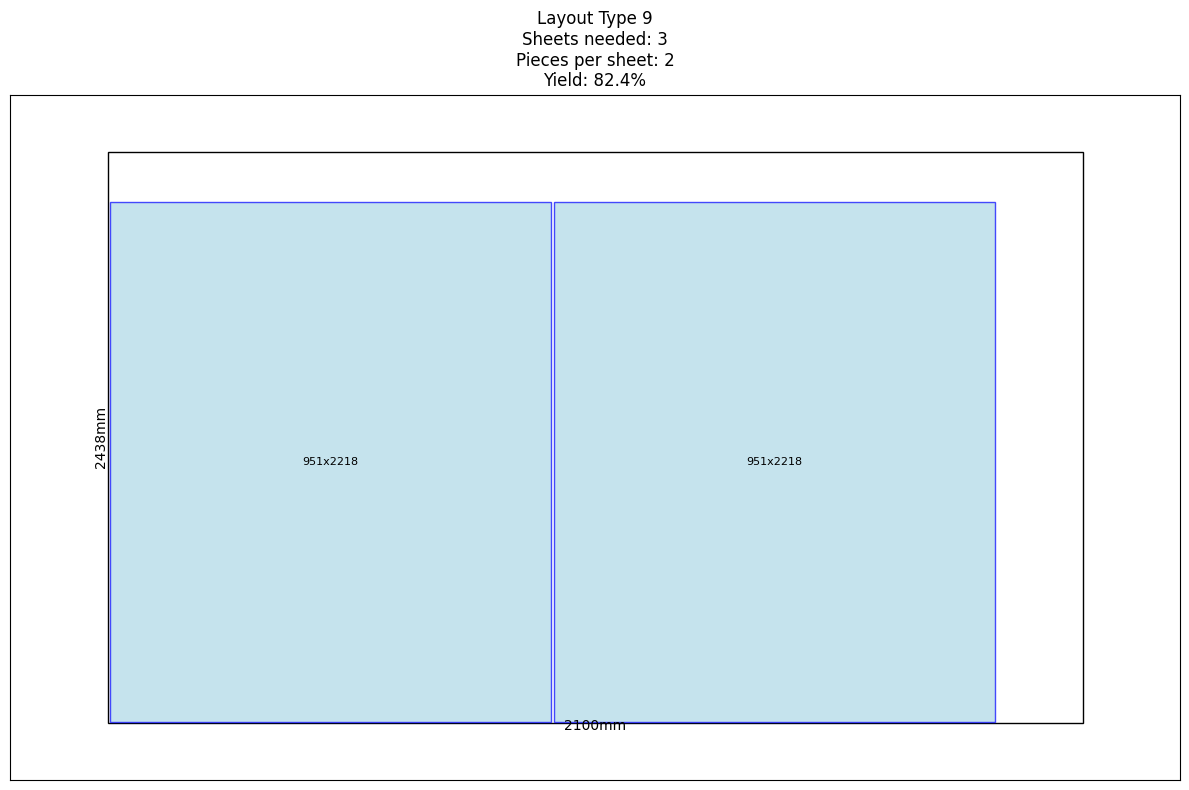

Total pieces: 260
Pieces placed: 52
Unique layout types: 9
Total sheets used: 26
Average Yield: 85.6%


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple, Dict
from collections import defaultdict

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

def optimize_sheet(stock_size: Tuple[int, int], pieces: List[Tuple[int, int]], spacing: int = 5):
    stock_width, stock_height = stock_size
    placements = []
    
    # Try different piece arrangements
    for rotation in [False, True]:
        current_placements = []
        current_x = spacing
        current_y = spacing
        row_height = 0
        
        sorted_pieces = sorted(pieces, key=lambda x: (-max(x), -min(x)))
        remaining = sorted_pieces.copy()
        
        while remaining:
            piece = remaining[0]
            width, height = piece if not rotation else (piece[1], piece[0])
            
            # Try to place in current row
            if current_x + width + spacing <= stock_width and current_y + height + spacing <= stock_height:
                current_placements.append((current_x, current_y, width, height))
                current_x += width + spacing
                row_height = max(row_height, height)
                remaining.pop(0)
            # Try next row
            elif current_y + row_height + spacing + height + spacing <= stock_height:
                current_x = spacing
                current_y += row_height + spacing
                row_height = 0
            else:
                break
        
        # Calculate yield for this arrangement
        if current_placements:
            total_area = sum(w * h for _, _, w, h in current_placements)
            current_yield = (total_area / (stock_width * stock_height)) * 100
            
            # Keep this arrangement if it has better yield
            if current_yield > 82 and (not placements or current_yield > sum(w * h for _, _, w, h in placements) / (stock_width * stock_height) * 100):
                placements = current_placements
    
    return placements, [p for p in pieces if p not in [(w, h) for _, _, w, h in placements]]

def visualize_layout(stock_size: Tuple[int, int], placements: List[Tuple[int, int]], title: str):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    
    # Draw stock sheet
    plt.gca().add_patch(plt.Rectangle((0, 0), stock_size[0], stock_size[1], 
                                    fill=False, edgecolor='black'))
    
    # Add stock sheet dimensions outside
    plt.text(stock_size[0]/2, -30, f'{stock_size[0]}mm', ha='center')
    plt.text(-30, stock_size[1]/2, f'{stock_size[1]}mm', va='center', rotation=90)
    
    # Draw pieces with optimized spacing
    for x, y, w, h in placements:
        rect = plt.Rectangle((x, y), w, h, 
                           facecolor='lightblue', 
                           edgecolor='blue', 
                           alpha=0.7)
        plt.gca().add_patch(rect)
        plt.text(x + w/2, y + h/2, f'{w}x{h}', 
                ha='center', va='center', fontsize=8)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Adjust margins to show outside measurements
    plt.margins(x=0.1, y=0.1)
    plt.tight_layout()
    plt.show()

def visualize_unique_layouts(stock_sizes: List[Dict], pieces: List[Tuple[int, int]]):
    piece_inventory = defaultdict(int)
    for piece in pieces:
        piece_inventory[piece] += 1
    
    total_pieces = len(pieces)
    total_placed = 0
    total_yield = 0
    layout_groups = defaultdict(int)
    remaining_inventory = piece_inventory.copy()
    
    for stock in stock_sizes:
        stock_size = (stock['length'], stock['width'])
        available_sheets = stock['qty']
        
        while available_sheets > 0 and any(remaining_inventory.values()):
            current_pieces = []
            for piece, count in remaining_inventory.items():
                if count > 0:
                    current_pieces.extend([piece] * count)
            
            placements, unplaced = optimize_sheet(stock_size, current_pieces)
            if not placements:
                break
            
            # Count used pieces
            used_pieces = defaultdict(int)
            for x, y, w, h in placements:
                piece = (w, h)
                used_pieces[piece] += 1
            
            # Calculate max sheets possible
            max_sheets = available_sheets
            for piece, used_count in used_pieces.items():
                if used_count > 0:
                    max_sheets = min(max_sheets, remaining_inventory[piece] // used_count)
            
            if max_sheets <= 0:
                break
                
            # Calculate yield
            yield_pct = (sum(w * h for (x, y, w, h) in placements) / 
                        (stock_size[0] * stock_size[1])) * 100
            
            if yield_pct >= 82:
                # Update tracking
                layout_key = tuple(sorted(placements))
                layout_groups[layout_key] += max_sheets
                total_yield += yield_pct * max_sheets
                
                # Update remaining inventory
                for piece, used_count in used_pieces.items():
                    remaining_inventory[piece] -= used_count * max_sheets
                
                total_placed += sum(used_pieces.values()) * max_sheets
                available_sheets -= max_sheets
                
                visualize_layout(
                    stock_size,
                    placements,
                    f'Layout Type {len(layout_groups)}\n'
                    f'Sheets needed: {max_sheets}\n'
                    f'Pieces per sheet: {len(placements)}\n'
                    f'Yield: {yield_pct:.1f}%'
                )
    
    total_sheets = sum(layout_groups.values())
    print(f"Total pieces: {total_pieces}")
    print(f"Pieces placed: {total_placed}")
    print(f"Unique layout types: {len(layout_groups)}")
    print(f"Total sheets used: {total_sheets}")
    if total_sheets > 0:
        print(f"Average Yield: {total_yield/total_sheets:.1f}%")

def main():
    # Load data from files
    glass_data = load_glass_data('data/glass_data.csv')
    stock_sizes = load_stock_sizes('data/glass_sheet_size.csv')
    
    # Prepare pieces for optimization
    pieces = [(item['length'], item['height']) for item in glass_data for _ in range(item['qty'])]
    
    # Visualize layouts
    visualize_unique_layouts(stock_sizes, pieces)

if __name__ == "__main__":
    main()

In [10]:
import pandas as pd
import numpy as np
import csv
from ortools.linear_solver import pywraplp

# Load the data
glass_data = pd.read_csv('data/glass_data.csv')
stock_sizes = pd.read_csv('data/glass_sheet_size.csv')

# Initialize the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Variables: Number of sheets used for each stock size
x = [solver.IntVar(0, int(stock_sizes.iloc[i]['qty']), f'x{i}') for i in range(len(stock_sizes))]

# Calculate the total area needed for the glass parts in square meters
total_area_needed = sum(row['glass_length'] * row['glass_height'] * row['glass_qty'] / 1000000 for _, row in glass_data.iterrows())

# Constraints: Ensure all glass pieces are cut
for i, row in glass_data.iterrows():
    glass_area = row['glass_length'] * row['glass_height'] * row['glass_qty'] / 1000000
    solver.Add(sum(x[j] * stock_sizes.iloc[j]['length'] * stock_sizes.iloc[j]['width'] / 1000000 for j in range(len(stock_sizes))) >= glass_area)

# Objective: Minimize wastage (unused area)
total_stock_area = sum(x[j] * stock_sizes.iloc[j]['length'] * stock_sizes.iloc[j]['width'] / 1000000 for j in range(len(stock_sizes)))
solver.Minimize(total_stock_area - total_area_needed)

# Solve the problem
status = solver.Solve()

# Check if a solution was found
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found!")
    for i in range(len(stock_sizes)):
        print(f"Stock size {stock_sizes.iloc[i]['length']}x{stock_sizes.iloc[i]['width']} used: {x[i].solution_value()} sheets")
    print(f"Total wastage: {solver.Objective().Value():.2f} sqm")
else:
    print("No optimal solution found.")


Optimal solution found!
Stock size 2100x2438 used: 0.0 sheets
Stock size 2438x2100 used: 6.0 sheets
Stock size 3300x2100 used: 13.0 sheets
Stock size 2100x3300 used: 0.0 sheets
Stock size 3300x2438 used: 0.0 sheets
Stock size 2438x3300 used: 0.0 sheets
Total wastage: -330.33 sqm
